# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT 

3. Analyze dimers binding energies \
    a. Preliminary plots in FIG03 \
    b. Do extrapolations w/ w/o Jopt on molecules & comparison with CCSD(T) results \
    c. Define gold, silver, bronze schemes, and their cost

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper


In [4]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from def_colors import map_DMC, dmc_color, dft_color

from define_setup import *

In [8]:
# Read mol_info
#with open( 'mol_info.pkl', 'rb' ) as f:
#    mol_info = pickle.load( f )
#mol_info

df_mol_info = pd.read_csv( 'mol_info.csv', index_col=0 )
#print('*** df_mol_info ***')
#print(df_mol_info)
df_mol_info

ref   test          name              formula  \
mol                                                            
AcNH2         21_1   True     acetamide           H3C-CO-NH2   
AcOH          20_1   True   acetic acid             H3C-COOH   
Benzene       24_1  False       benzene                 C6H6   
Cyclopentane  37_1   True  cyclopentane               (CH2)5   
Ethene        30_2  False        ethene              H2C=CH2   
Ethyne        32_2  False        ethyne              HC---CH   
MeNH2         56_2  False   methylamine              H3C-NH2   
MeOH          55_2  False      methanol               H3C-OH   
Neopentane    36_1  False    neopentane              C(CH3)4   
Pentane       34_1  False       pentane  H3C-CH2-CH2-CH2-CH3   
Peptide       57_2   True       peptide        H3C-CO-NH-CH3   
Pyridine      25_1  False      pyridine                NC5H5   
Uracil        26_1   True        uracil             H4C4N2O2   
Water         01_2  False         water                  H2O   

                                          atoms  Nel  Nelv  
mol                                                         
AcNH2          {'H': 5, 'C': 2, 'N': 1, 'O': 1}   32    24  
AcOH           {'H': 4, 'C': 2, 'N': 0, 'O': 2}   32    24  
Benzene        {'H': 6, 'C': 6, 'N': 0, 'O': 0}   42    30  
Cyclopentane  {'H': 10, 'C': 5, 'N': 0, 'O': 0}   40    30  
Ethene         {'H': 4, 'C': 2, 'N': 0, 'O': 0}   16    12  
Ethyne         {'H': 2, 'C': 2, 'N': 0, 'O': 0}   14    10  
MeNH2          {'H': 5, 'C': 1, 'N': 1, 'O': 0}   18    14  
MeOH           {'H': 4, 'C': 1, 'N': 0, 'O': 1}   18    14  
Neopentane    {'H': 12, 'C': 5, 'N': 0, 'O': 0}   42    32  
Pentane       {'H': 12, 'C': 5, 'N': 0, 'O': 0}   42    32  
Peptide        {'H': 7, 'C': 3, 'N': 1, 'O': 1}   40    30  
Pyridine       {'H': 5, 'C': 5, 'N': 1, 'O': 0}   42    30  
Uracil         {'H': 4, 'C': 4, 'N': 2, 'O': 2}   58    42  
Water          {'H': 2, 'C': 0, 'N': 0, 'O': 1}   10     8

In [7]:
# Read mol_info
#with open( 'dim_info.pkl', 'rb' ) as f:
#    dim_info = pickle.load( f )
#dim_info

df_dim_info = pd.read_csv( 'dim_info.csv', index_col=0 )
#print('\n*** df_dim_info ***')
#print(df_dim_info)
df_dim_info

name      mol1      mol2  Nel  Nelv  \
ID                                                      
1       01_Water-Water     Water     Water   20    16   
2        02_Water-MeOH     Water      MeOH   28    22   
3       03_Water-MeNH2     Water     MeNH2   28    22   
4     04_Water-Peptide     Water   Peptide   50    38   
5         05_MeOH-MeOH      MeOH      MeOH   36    28   
..                 ...       ...       ...  ...   ...   
62    62_Pentane-AcNH2   Pentane     AcNH2   74    56   
63     63_Benzene-AcOH   Benzene      AcOH   74    54   
64   64_Peptide-Ethene   Peptide    Ethene   56    42   
65  65_Pyridine-Ethyne  Pyridine    Ethyne   56    40   
66   66_MeNH2-Pyridine     MeNH2  Pyridine   60    44   

                                atoms  
ID                                     
1    {'H': 4, 'C': 0, 'N': 0, 'O': 2}  
2    {'H': 6, 'C': 1, 'N': 0, 'O': 2}  
3    {'H': 7, 'C': 1, 'N': 1, 'O': 1}  
4    {'H': 9, 'C': 3, 'N': 1, 'O': 2}  
5    {'H': 8, 'C': 2, 'N': 0, 'O': 2}  
..                                ...  
62  {'H': 17, 'C': 7, 'N': 1, 'O': 1}  
63  {'H': 10, 'C': 8, 'N': 0, 'O': 2}  
64  {'H': 11, 'C': 5, 'N': 1, 'O': 1}  
65   {'H': 7, 'C': 7, 'N': 1, 'O': 0}  
66  {'H': 10, 'C': 6, 'N': 2, 'O': 0}  

[66 rows x 6 columns]

In [9]:
#with open( dir_analysis+'results_dim.pkl', 'rb' ) as f:
#    results_dim = pickle.load( f )

# results_dim[ dim_id ][ dmc_type ][ tau ] 
# results_dim[1]#['DMCdla5']['0.01']

dfd = pd.read_csv('results_dim.csv', index_col=0)
dfd

mol1      mol2 dmc_type dmc_Jas    tau           ene       err  \
0    Water     Water   DMCtm5  JoptLA  0.100 -21599.485846  0.026789   
1    Water     Water   DMCtm5  JoptLA  0.006 -21594.853751  0.020971   
2    Water     Water   DMCtm5  JoptLA  0.030 -21594.742661  0.021172   
3    Water     Water   DMCtm5  JoptLA  0.020 -21594.575269  0.022685   
4    Water     Water   DMCtm5  JoptLA  0.003 -21595.005430  0.021478   
..     ...       ...      ...     ...    ...           ...       ...   
568  MeNH2  Pyridine  DMCdla5    Jopt  0.040 -37579.985077  0.038614   
569  MeNH2  Pyridine  DMCdla5    Jopt  0.030 -37580.059017  0.038989   
570  MeNH2  Pyridine  DMCdla5    Jopt  0.020 -37580.112816  0.050216   
571  MeNH2  Pyridine  DMCdla5    Jopt  0.050 -37580.056020  0.044532   
572  MeNH2  Pyridine  DMCdla5    Jopt  0.100 -37581.835062  0.046007   

        units  TotTimeSim[au]           Pop   Pop-err   Var[au]  tau_eff[au]  \
0    kcal/mol          1050.0  63628.209423  1.332910  0.596352     0.085425   
1    kcal/mol          1203.0  63979.908783  0.289924  0.548435     0.005972   
2    kcal/mol          1215.0  63898.234203  0.615966  0.572748     0.028863   
3    kcal/mol          1010.0  63929.393700  0.567137  0.552755     0.019541   
4    kcal/mol          1021.5  63990.798076  0.226181  0.541881     0.002994   
..        ...             ...           ...       ...       ...          ...   
568  kcal/mol          1220.0  63975.611570  0.976428  0.873872     0.038792   
569  kcal/mol          1215.0  63969.280835  0.810208  0.861702     0.029372   
570  kcal/mol          1010.0  63988.132160  0.811182  0.904968     0.019754   
571  kcal/mol          1275.0  63975.802134  1.001893  0.877498     0.048007   
572  kcal/mol          1050.0  63937.706154  1.550407  0.820943     0.090950   

     corr-time[au]                                         machine  N_MPI  \
0         0.190280              linuxpc-intel-slurm-parallel.peta4   64.0   
1         0.116834              linuxpc-intel-slurm-parallel.peta4   64.0   
2         0.134879              linuxpc-intel-slurm-parallel.peta4   64.0   
3         0.126479              linuxpc-intel-slurm-parallel.peta4   64.0   
4         0.114310              linuxpc-intel-slurm-parallel.peta4  128.0   
..             ...                                             ...    ...   
568       0.416130  linuxpc-intel-slurm-parallel.peta4-icelake-zen  304.0   
569       0.387901          linuxpc-intel-slurm-parallel.peta4-knl  320.0   
570       0.428184  linuxpc-intel-slurm-parallel.peta4-icelake-zen  304.0   
571       0.403481       linuxpc-intel-slurm-parallel.peta4-cclake  224.0   
572       0.442735          linuxpc-intel-slurm-parallel.peta4-knl  320.0   

         cost  target_weight  ID  tau[au]  
0    0.922111        64000.0   1    0.100  
1    0.897990        64000.0   1    0.006  
2    0.892656        64000.0   1    0.030  
3    0.916368        64000.0   1    0.020  
4    0.449383        64000.0   1    0.003  
..        ...            ...  ..      ...  
568  0.484553        64000.0  66    0.040  
569  4.261544        64000.0  66    0.030  
570  0.481800        64000.0  66    0.020  
571  0.866439        64000.0  66    0.050  
572  4.280929        64000.0  66    0.100  

[573 rows x 20 columns]

In [10]:
# Read results monomer
#with open( dir_analysis+'results_mol.pkl', 'rb' ) as f:
#    results_mol = pickle.load( f )

dfm = pd.read_csv('results_mol.csv', index_col=0)
dfm

mol mol_id dmc_type dmc_Jas    tau           ene       err     units  \
0    AcNH2   21_1  DMCdla5    Jopt  0.100 -25292.992144  0.030754  kcal/mol   
1    AcNH2   21_1  DMCdla5    Jopt  0.050 -25290.438988  0.029997  kcal/mol   
2    AcNH2   21_1  DMCdla5    Jopt  0.020 -25289.921470  0.035623  kcal/mol   
3    AcNH2   21_1  DMCdla5    Jopt  0.030 -25289.971374  0.031483  kcal/mol   
4    AcNH2   21_1  DMCdla5    Jopt  0.040 -25290.159667  0.030095  kcal/mol   
..     ...    ...      ...     ...    ...           ...       ...       ...   
358  Water   01_2   DMCtm5    Jopt  0.010 -10794.485530  0.014532  kcal/mol   
359  Water   01_2   DMCtm5    Jopt  0.060 -10794.460234  0.016265  kcal/mol   
360  Water   01_2   DMCtm5    Jopt  0.030 -10794.151875  0.014278  kcal/mol   
361  Water   01_2   DMCtm5    Jopt  0.006 -10794.661346  0.013322  kcal/mol   
362  Water   01_2   DMCtm5    Jopt  0.100 -10795.655569  0.018736  kcal/mol   

     TotTimeSim[au]           Pop   Pop-err   Var[au]  tau_eff[au]  \
0            1050.0  63920.817019  1.315471  0.596108     0.088849   
1            1275.0  63975.752253  0.883435  0.584934     0.047457   
2            1010.0  63977.959200  0.639359  0.599023     0.019673   
3            1215.0  63964.995992  0.721060  0.616691     0.029181   
4            1220.0  63974.552628  0.829389  0.591824     0.038443   
..              ...           ...       ...       ...          ...   
358          1005.0  63985.241357  0.336620  0.257304     0.009911   
359          1230.0  63903.210692  0.716164  0.273279     0.055115   
360          1215.0  63961.069785  0.516133  0.263953     0.028912   
361          1203.0  63990.242067  0.243849  0.263548     0.005973   
362          1050.0  63814.479135  1.016734  0.284993     0.085952   

     corr-time[au]                                         machine  N_MPI  \
0         0.343110          linuxpc-intel-slurm-parallel.peta4-knl  320.0   
1         0.289681       linuxpc-intel-slurm-parallel.peta4-cclake  112.0   
2         0.296100  linuxpc-intel-slurm-parallel.peta4-icelake-zen  152.0   
3         0.307369          linuxpc-intel-slurm-parallel.peta4-knl  320.0   
4         0.276016  linuxpc-intel-slurm-parallel.peta4-icelake-zen  152.0   
..             ...                                             ...    ...   
358       0.114259              linuxpc-intel-slurm-parallel.peta4   64.0   
359       0.166638              linuxpc-intel-slurm-parallel.peta4   64.0   
360       0.127382              linuxpc-intel-slurm-parallel.peta4   64.0   
361       0.117786              linuxpc-intel-slurm-parallel.peta4   64.0   
362       0.205363              linuxpc-intel-slurm-parallel.peta4   64.0   

         cost  target_weight  tau[au]  
0    2.067617        64000.0    0.100  
1    0.690792        64000.0    0.050  
2    0.378092        64000.0    0.020  
3    2.068576        64000.0    0.030  
4    0.379274        64000.0    0.040  
..        ...            ...      ...  
358  0.360866        64000.0    0.010  
359  0.360513        64000.0    0.060  
360  0.363396        64000.0    0.030  
361  0.364060        64000.0    0.006  
362  0.365928        64000.0    0.100  

[363 rows x 19 columns]

In [11]:
df_refs = pd.read_csv( 'Refs.csv', index_col=0 )
df_refs

name  Hobza_1  Hobza_2  Martin_newBronze  Martin_Silver  \
1       01 Water-Water    -4.92    -5.01            -4.915         -4.982   
2        02 Water-MeOH    -5.59    -5.70            -5.589         -5.666   
3       03 Water-MeNH2    -6.91    -7.04            -6.894         -6.986   
4     04 Water-Peptide    -8.10    -8.22            -8.089         -8.183   
5         05 MeOH-MeOH    -5.76    -5.85            -5.773         -5.822   
..                 ...      ...      ...               ...            ...   
62    62 Pentane-AcNH2    -3.53    -3.53            -3.458         -3.491   
63     63 Benzene-AcOH    -3.80    -3.75            -3.715         -3.709   
64   64 Peptide-Ethene    -3.00    -3.00            -2.945         -2.967   
65  65 Pyridine-Ethyne    -3.99    -4.10            -4.065         -4.064   
66   66 MeNH2-Pyridine    -3.97    -3.97            -3.907         -3.930   

    Martin_Gold  Martin_PCCP2022  14k-Gold  
1        -4.979           -4.946    -4.991  
2        -5.666           -5.627    -5.674  
3        -6.985           -6.941    -6.996  
4           NaN           -8.128    -8.191  
5        -5.824           -5.804    -5.827  
..          ...              ...       ...  
62          NaN           -3.437    -3.495  
63          NaN           -3.671    -3.716  
64          NaN           -2.928    -2.977  
65          NaN           -4.066    -4.071  
66          NaN           -3.893    -3.931  

[66 rows x 8 columns]

In [12]:
df_refs.loc[1,'Hobza_1']

-4.92

# XXX CONTINUE HERE XXX

In [4]:
# Reading the evaluation in 03a_* 
# of DMC binding energies of all dimers, i=1,...,66, 
# into a Pamdas DataFrame, reporting Eb, error, dmc_type, dmc_Jas, name, ...
# Final DataFrame is obtained from the concatenation of individual dataframes,
# each for a different dimer and a different DMC setup


#Edimer = pd.read_csv('Edimer.csv', index_col=0)

Eb = pd.read_csv('Eb.csv', index_col=0)

Eb_1ref = pd.read_csv('Eb_1ref.csv', index_col=0)

Eb

ene       err               name   i dmc_type   Jas Jas_mol  \
0   -2.466741  0.046796     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
1   -2.962955  0.037100     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
2   -3.599663  0.032754     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
3   -4.285075  0.035724     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
4   -4.197201  0.185923     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
..        ...       ...                ...  ..      ...   ...     ...   
444 -3.976514  0.048291  66_MeNH2-Pyridine  66  DMCdla5  Jopt    Jopt   
445 -3.995998  0.064844  66_MeNH2-Pyridine  66  DMCdla5  Jopt    Jopt   
446 -3.625580  0.063502  66_MeNH2-Pyridine  66  DMCdla5  Jopt  Jdimer   
447 -3.938631  0.049563  66_MeNH2-Pyridine  66  DMCdla5  Jopt  Jdimer   
448 -3.906021  0.064765  66_MeNH2-Pyridine  66  DMCdla5  Jopt  Jdimer   

        delta    tau  
0    0.030971  0.100  
1    0.030971  0.060  
2    0.030971  0.030  
3    0.030971  0.010  
4    0.030971  0.006  
..        ...    ...  
444  0.001287  0.030  
445  0.001287  0.010  
446  0.001287  0.100  
447  0.001287  0.030  
448  0.001287  0.010  

[449 rows x 9 columns]

In [5]:
d = Edimer[ Edimer['i']==1 ]
d.loc[ d['tau'] <= 0.03, : ]

ene       err     units  TotTimeSim[au]           Pop   Pop-err  \
2  -21593.206610  0.019761  kcal/mol          1215.0  63953.916472  0.655075   
3  -21593.902714  0.022036  kcal/mol          1005.0  63984.356412  0.414554   
4  -21594.285384  0.024074  kcal/mol           777.0  63982.548927  0.363725   
5  -21594.598270  0.038373  kcal/mol           388.5  64011.054103  0.368187   
7  -21594.742661  0.021172  kcal/mol          1215.0  63898.234203  0.615966   
8  -21594.575269  0.022685  kcal/mol          1010.0  63929.393700  0.567137   
9  -21594.658280  0.020500  kcal/mol          1005.0  63963.003226  0.419906   
12 -21604.400931  0.023147  kcal/mol          1215.0  63980.995992  0.650140   
13 -21603.920124  0.026118  kcal/mol          1005.0  63980.922010  0.433089   
14 -21603.974571  0.025260  kcal/mol          1201.5  63994.582792  0.219845   
15 -21604.034267  0.024686  kcal/mol          1000.5  63991.396458  0.141569   

     Var[au]  tau_eff[au]  corr-time[au]  \
2   0.552120     0.028862       0.131564   
3   0.540201     0.009906       0.125939   
4   0.535780     0.005972       0.135900   
5   0.534968     0.002994       0.124343   
7   0.572748     0.028863       0.134879   
8   0.552755     0.019541       0.126479   
9   0.548701     0.009906       0.117862   
12  0.523861     0.028883       0.180863   
13  0.537514     0.009908       0.196763   
14  0.540806     0.002995       0.178317   
15  0.531294     0.001000       0.168011   

                                      machine  N_MPI      cost  target_weight  \
2          linuxpc-intel-slurm-parallel.peta4   64.0  0.902262        64000.0   
3          linuxpc-intel-slurm-parallel.peta4   64.0  0.883902        64000.0   
4                                         NaN    NaN       NaN            NaN   
5                                         NaN    NaN       NaN            NaN   
7          linuxpc-intel-slurm-parallel.peta4   64.0  0.892656        64000.0   
8          linuxpc-intel-slurm-parallel.peta4   64.0  0.916368        64000.0   
9          linuxpc-intel-slurm-parallel.peta4   64.0  0.891023        64000.0   
12         linuxpc-intel-slurm-parallel.peta4  128.0  0.275161        64000.0   
13         linuxpc-intel-slurm-parallel.peta4  128.0  0.273290        64000.0   
14         linuxpc-intel-slurm-parallel.peta4  960.0  0.079150        64000.0   
15  linuxpc-intel-slurm-parallel.peta4-cclake  112.0  0.333377        64000.0   

      tau            name  i dmc_type   Jas  Nelv  
2   0.030  01_Water-Water  1   DMCtm5  Jopt    16  
3   0.010  01_Water-Water  1   DMCtm5  Jopt    16  
4   0.006  01_Water-Water  1   DMCtm5  Jopt    16  
5   0.003  01_Water-Water  1   DMCtm5  Jopt    16  
7   0.030  01_Water-Water  1   DMCtm5  Jopt    16  
8   0.020  01_Water-Water  1   DMCtm5  Jopt    16  
9   0.010  01_Water-Water  1   DMCtm5  Jopt    16  
12  0.030  01_Water-Water  1  DMCdla5  Jopt    16  
13  0.010  01_Water-Water  1  DMCdla5  Jopt    16  
14  0.003  01_Water-Water  1  DMCdla5  Jopt    16  
15  0.001  01_Water-Water  1  DMCdla5  Jopt    16

In [6]:
from scipy.optimize import curve_fit

def fun_lin( x, a, b ):
    return a + b * x

def fun_quad( x, a, b, c ):
    return a + b * x + c * x**2

def fun_cub( x, a, b, c, d ):
    return a + b * x + c * x**2 + d * x**3


1 01_Water-Water
{'DMCdla5', 'DMCtm5'}
1 DMCdla5
1 DMCtm5
2 02_Water-MeOH
{'DMCdla5'}
2 DMCdla5
3 03_Water-MeNH2
{'DMCdla5'}
3 DMCdla5
4 04_Water-Peptide
{'DMCdla5'}
4 DMCdla5
5 05_MeOH-MeOH
{'DMCdla5'}
5 DMCdla5
6 06_MeOH-MeNH2
{'DMCdla5'}
6 DMCdla5
7 07_MeOH-Peptide
{'DMCdla5'}
7 DMCdla5
8 08_MeOH-Water
{'DMCdla5'}
8 DMCdla5
9 09_MeNH2-MeOH
{'DMCdla5'}
9 DMCdla5
10 10_MeNH2-MeNH2
{'DMCdla5'}
10 DMCdla5
11 11_MeNH2-Peptide
{'DMCdla5'}
11 DMCdla5
12 12_MeNH2-Water
{'DMCdla5'}
12 DMCdla5
13 13_Peptide-MeOH
{'DMCdla5'}
13 DMCdla5
14 14_Peptide-MeNH2
{'DMCdla5'}
14 DMCdla5
15 15_Peptide-Peptide
{'DMCdla5'}
15 DMCdla5
16 16_Peptide-Water
{'DMCdla5'}
16 DMCdla5
17 17_Uracil-Uracil_BP
{'DMCdla5'}
17 DMCdla5
18 18_Water-Pyridine
{'DMCdla5'}
18 DMCdla5
19 19_MeOH-Pyridine
{'DMCdla5'}
19 DMCdla5
20 20_AcOH-AcOH
{'DMCdla5', 'DMCtm5'}
20 DMCdla5
20 DMCtm5
21 21_AcNH2-AcNH2
{'DMCdla5'}
21 DMCdla5


<ipython-input-7-5b920fd9653c>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )


22 22_AcOH-Uracil
{'DMCdla5'}
22 DMCdla5
23 23_AcNH2-Uracil
{'DMCdla5'}
23 DMCdla5
24 24_Benzene-Benzene_pi-pi
{'DMCdla5'}
24 DMCdla5
25 25_Pyridine-Pyridine_pi-pi
{'DMCdla5', 'DMCdla', 'DMC'}
25 DMCdla5
25 DMCdla
25 DMC
26 26_Uracil-Uracil_pi-pi
{'DMCdla5', 'DMCdla'}
26 DMCdla5
26 DMCdla
27 27_Benzene-Pyridine_pi-pi
{'DMCdla5'}
27 DMCdla5
28 28_Benzene-Uracil_pi-pi
{'DMCdla5'}
28 DMCdla5
29 29_Pyridine-Uracil_pi-pi
{'DMCdla5'}
29 DMCdla5
30 30_Benzene-Ethene
{'DMCdla5'}
30 DMCdla5
31 31_Uracil-Ethene
{'DMCdla5'}
31 DMCdla5
32 32_Uracil-Ethyne
{'DMCdla5'}
32 DMCdla5
33 33_Pyridine-Ethene
{'DMCdla5'}
33 DMCdla5
34 34_Pentane-Pentane
{'DMCdla5'}
34 DMCdla5
35 35_Neopentane-Pentane
{'DMCdla5'}
35 DMCdla5
36 36_Neopentane-Neopentane
{'DMCdla5'}
36 DMCdla5
37 37_Cyclopentane-Neopentane
{'DMCdla5'}
37 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


38 38_Cyclopentane-Cyclopentane
{'DMCdla5'}
38 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


39 39_Benzene-Cyclopentane
{'DMCdla5'}
39 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


40 40_Benzene-Neopentane
{'DMCdla5'}
40 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


41 41_Uracil-Pentane
{'DMCdla5'}
41 DMCdla5
42 42_Uracil-Cyclopentane
{'DMCdla5'}
42 DMCdla5
43 43_Uracil-Neopentane
{'DMCdla5'}
43 DMCdla5
44 44_Ethene-Pentane
{'DMCdla5'}
44 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


45 45_Ethyne-Pentane
{'DMCdla5'}
45 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


46 46_Peptide-Pentane
{'DMCdla5'}
46 DMCdla5
47 47_Benzene-Benzene_TS
{'DMCdla5'}
47 DMCdla5
48 48_Pyridine-Pyridine_TS
{'DMCdla5'}
48 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


49 49_Benzene-Pyridine_TS
{'DMCdla5'}
49 DMCdla5
50 50_Benzene-Ethyne_CH-pi
{'DMCdla5'}
50 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


51 51_Ethyne-Ethyne_TS
{'DMCdla5'}
51 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


52 52_Benzene-AcOH_OH-pi
{'DMCdla5'}
52 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


53 53_Benzene-AcNH2_NH-pi
{'DMCdla5'}
53 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


54 54_Benzene-Water_OH-pi
{'DMCdla5'}
54 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


55 55_Benzene-MeOH_OH-pi
{'DMCdla5'}
55 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


56 56_Benzene-MeNH2_NH-pi
{'DMCdla5'}
56 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


57 57_Benzene-Peptide_NH-pi
{'DMCdla5'}
57 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


58 58_Pyridine-Pyridine_CH-N
{'DMCdla5'}
58 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


59 59_Ethyne-Water_CH-O
{'DMCdla5'}
59 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


60 60_Ethyne-AcOH_OH-pi
{'DMCdla5'}
60 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


61 61_Pentane-AcOH
{'DMCdla5'}
61 DMCdla5
62 62_Pentane-AcNH2
{'DMCdla5'}
62 DMCdla5
63 63_Benzene-AcOH
{'DMCdla5'}
63 DMCdla5
64 64_Peptide-Ethene
{'DMCdla5'}
64 DMCdla5
65 65_Pyridine-Ethyne
{'DMCdla5'}
65 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


66 66_MeNH2-Pyridine
{'DMCdla5'}
66 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


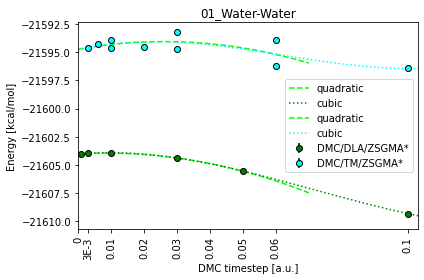

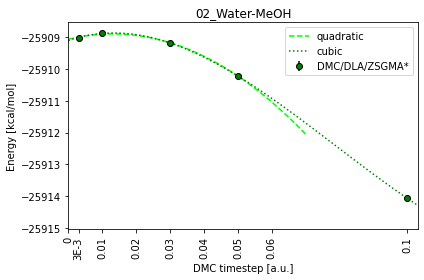

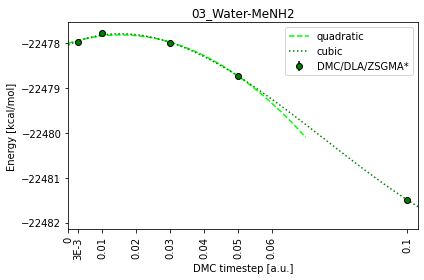

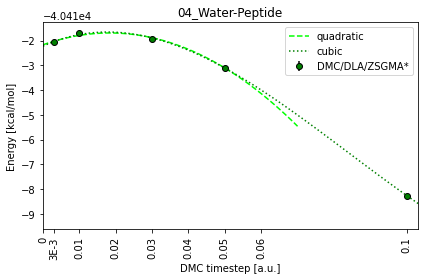

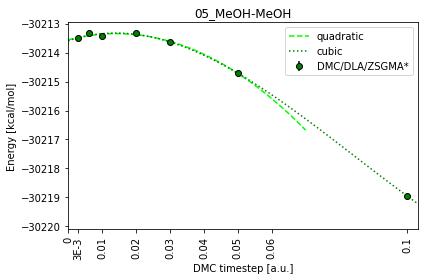

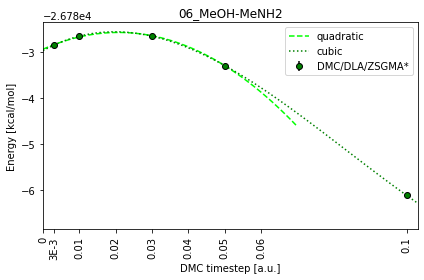

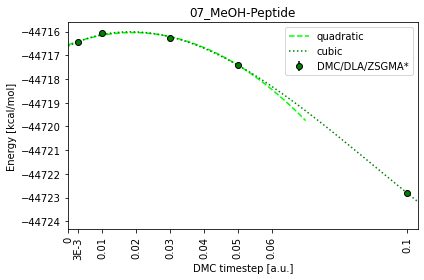

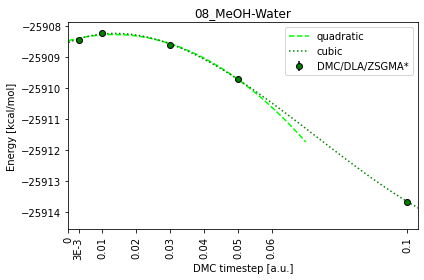

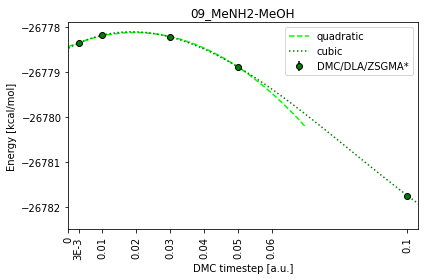

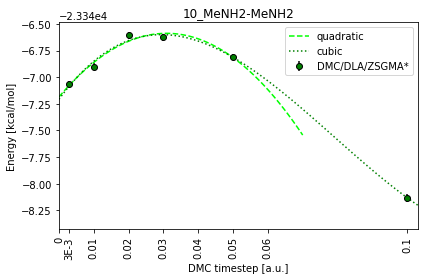

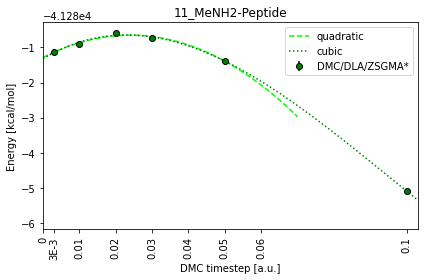

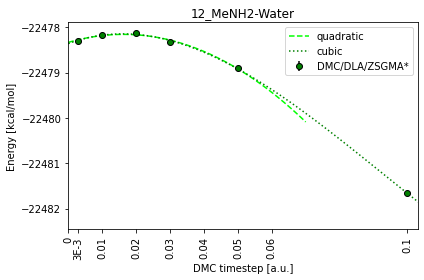

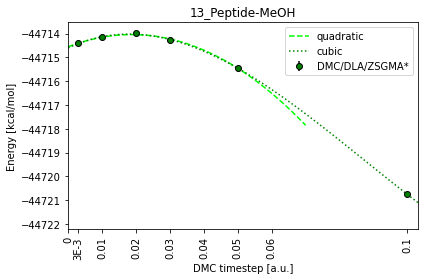

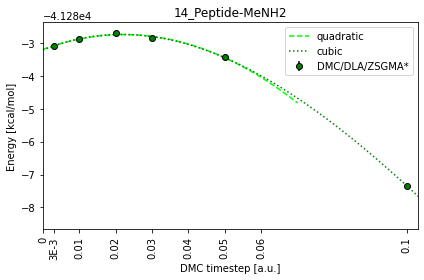

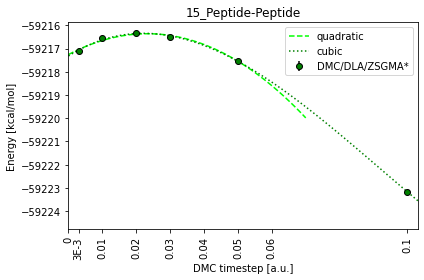

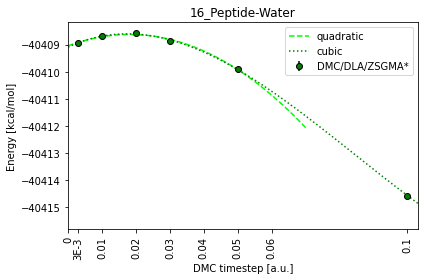

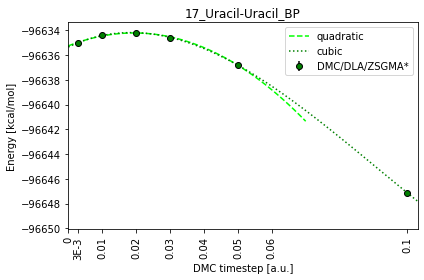

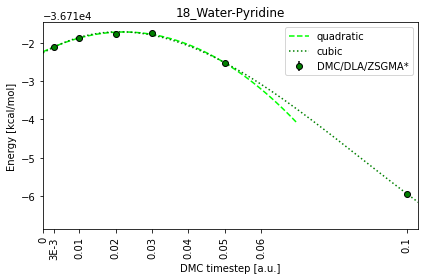

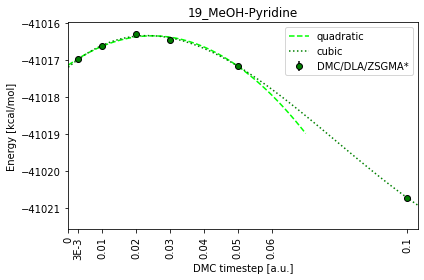

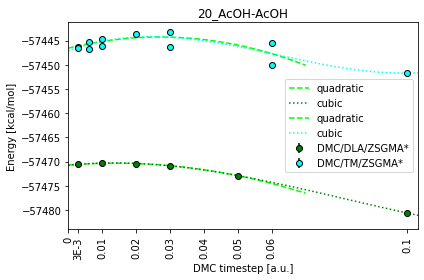

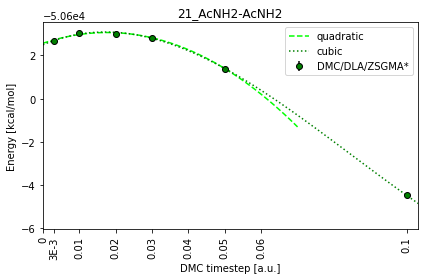

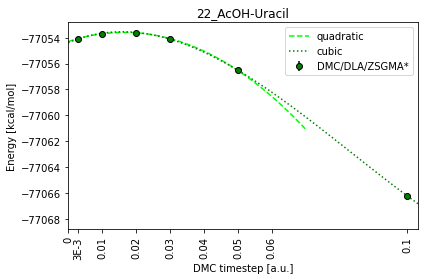

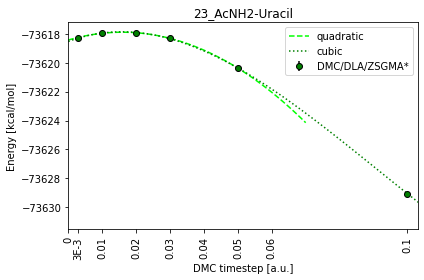

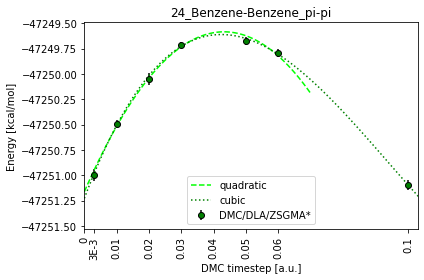

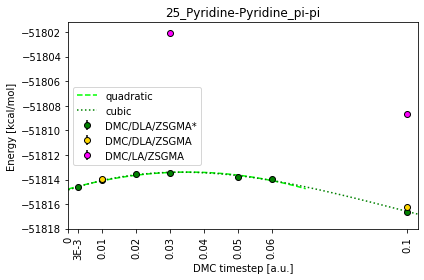

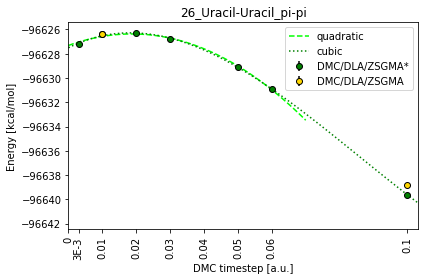

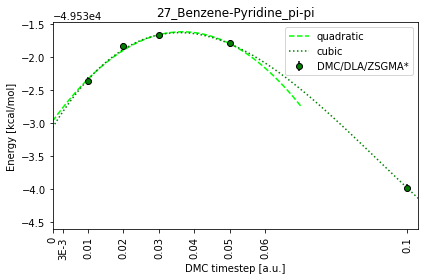

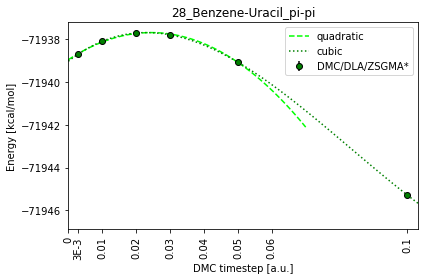

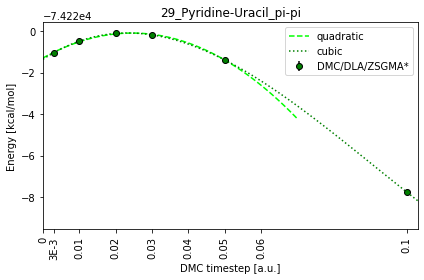

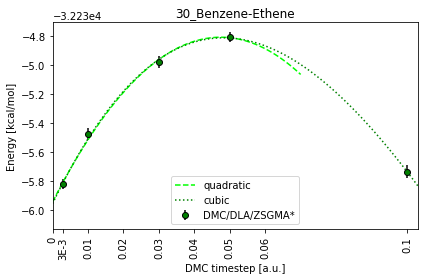

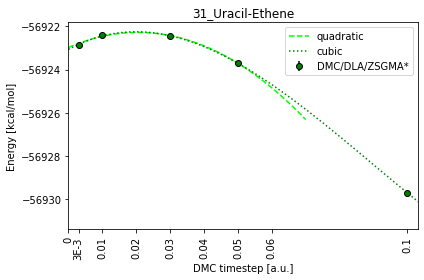

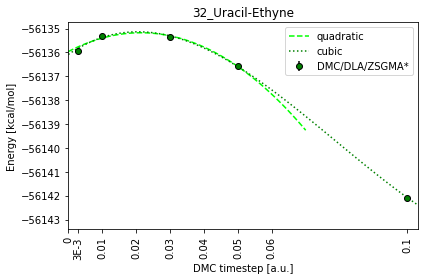

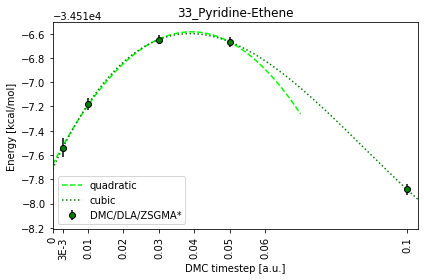

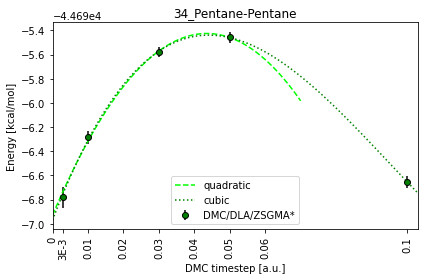

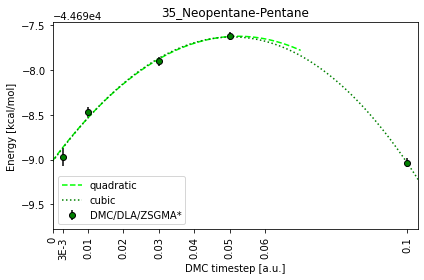

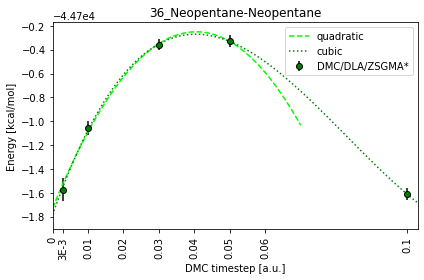

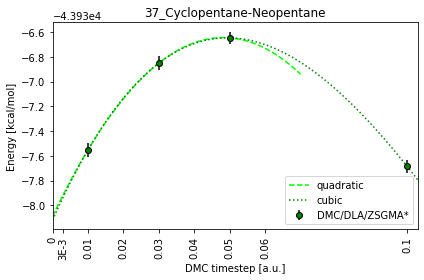

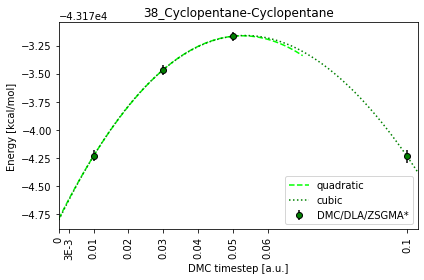

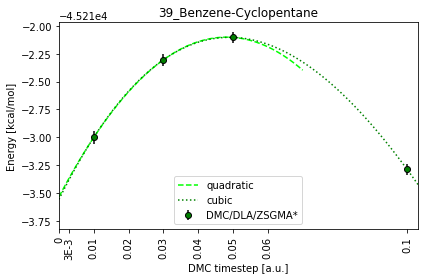

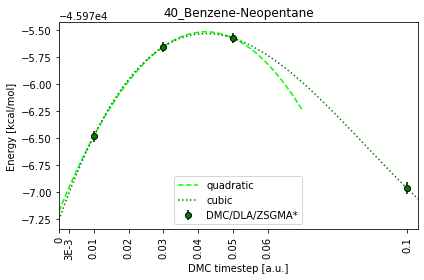

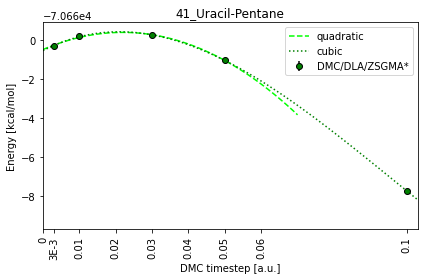

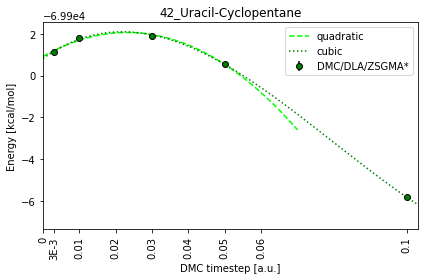

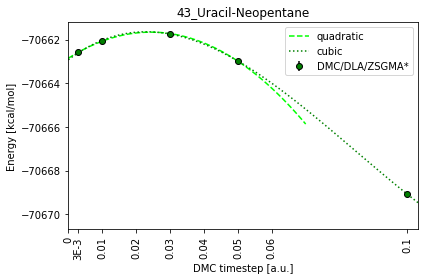

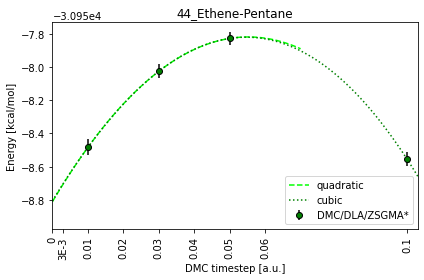

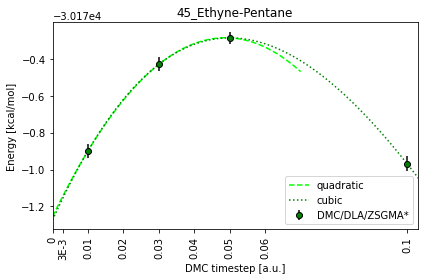

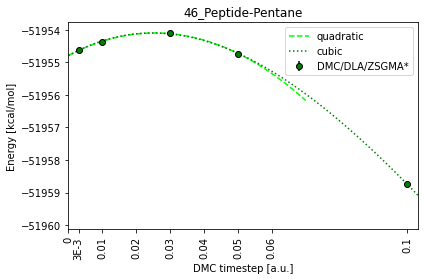

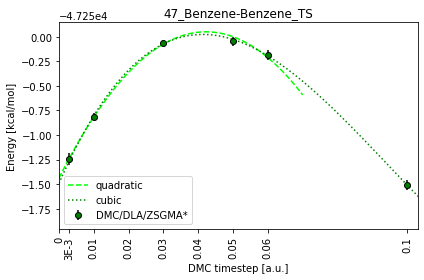

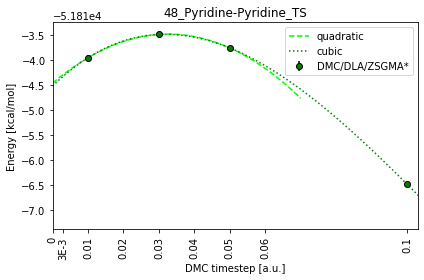

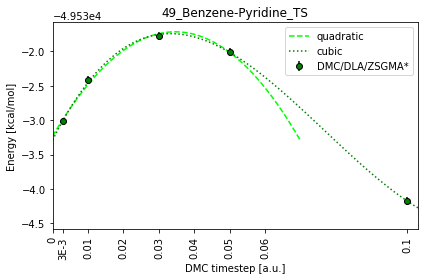

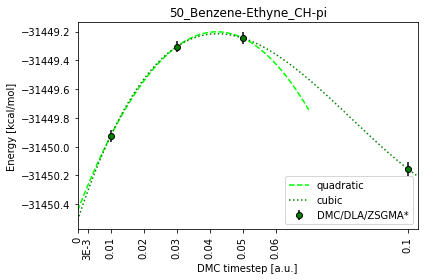

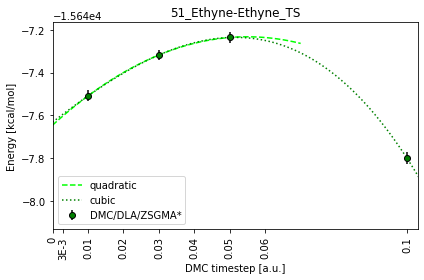

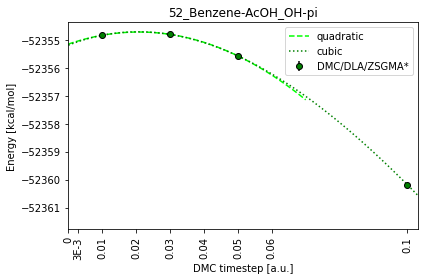

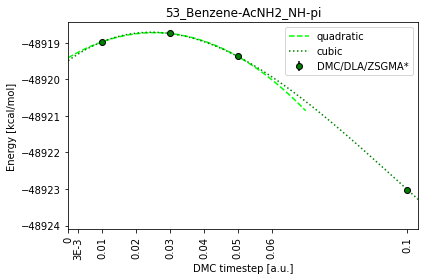

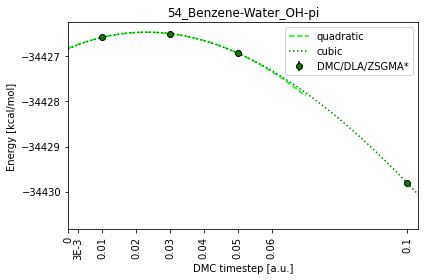

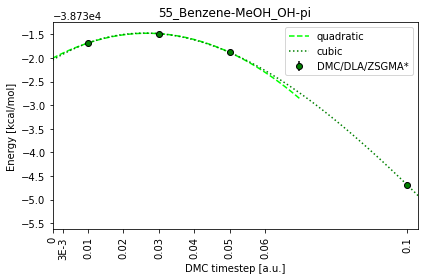

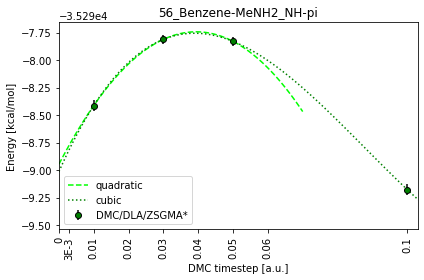

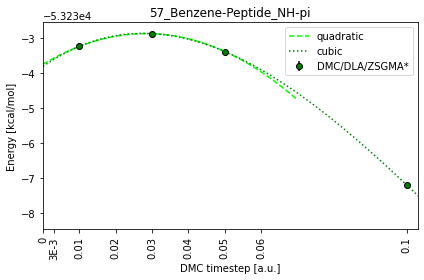

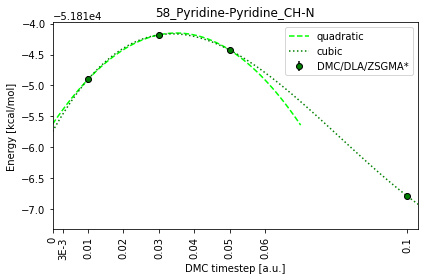

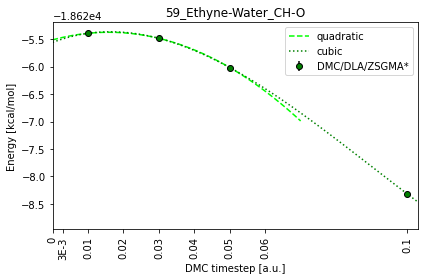

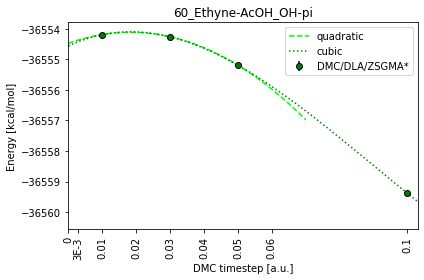

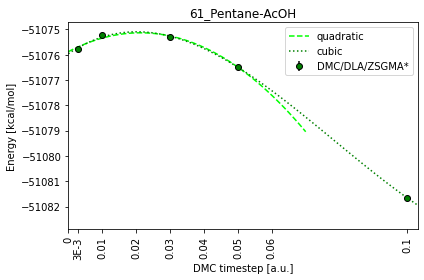

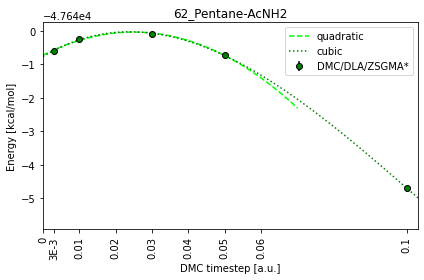

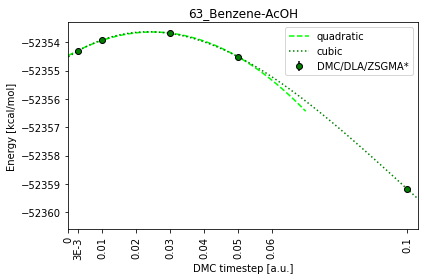

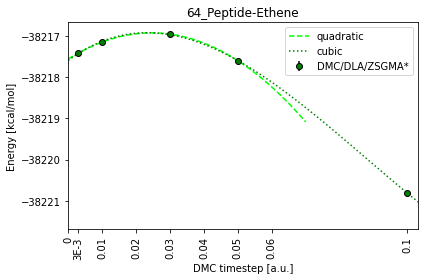

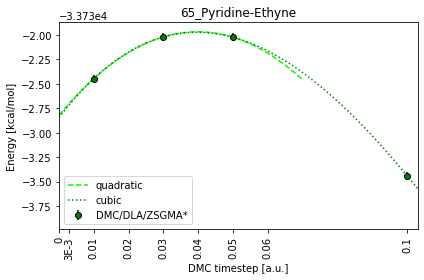

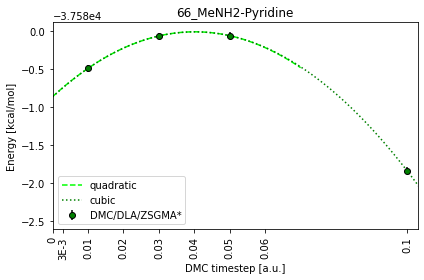

In [7]:
# Plot Total Energy for 66 dimers using dataframe Edimer

verbose = False

for i in range(1,67):
    d = Edimer[ Edimer['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1 ] )
    ax.set_xticklabels( [ '0', '3E-3', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    print(dmc_types)
    for dmc_type in dmc_types:
        print( f'{i} {dmc_type}' )

        dd = d[ d['dmc_type']==dmc_type ]
        X = dd['tau']
        Y = dd['ene']
        Yerr = dd['err']
        label = map_DMC( dmc_type )
        c = dmc_color( dmc_type )
        
        ax.errorbar( X, Y, Yerr, color='k', mfc=c, label=label, fmt='o' )
        #ax.errorbar( X, Y, Yerr, color=c, mec='k', label=label, fmt='o' )
        #ax.plot( X, Y, 'o:', label=label , color=c )
        
        try:
            taumaxfit = 0.06
            ddfit = dd[ dd['tau']<= taumaxfit ]
            xdata = ddfit['tau'].to_numpy()
            ydata = ddfit['ene'].to_numpy()
            sigma = ddfit['err'].to_numpy()
            popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata, sigma=sigma )
            xlinspace = np.linspace( 0, taumaxfit+0.01, 100 )
            funlinspace = fun_quad( xlinspace, *popt )
            ax.plot( xlinspace, funlinspace, '--', color='lime', label='quadratic' )
        except:
            pass

        try:
            taumaxfit = 0.10
            ddfit = dd[ dd['tau']<= taumaxfit ]
            xdata = ddfit['tau'].to_numpy()
            ydata = ddfit['ene'].to_numpy()
            sigma = ddfit['err'].to_numpy()
            popt, pcov = curve_fit( fun_cub, xdata=xdata, ydata=ydata, sigma=sigma )
            xlinspace = np.linspace( 0, taumaxfit+0.01, 100 )
            funlinspace = fun_cub( xlinspace, *popt )
            ax.plot( xlinspace, funlinspace, ':', color=c, label='cubic' )
        except:
            pass

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Etot_{i}.png',format='png',dpi=300)

1 01_Water-Water
1 DMCdla5 Jopt
fit Eb = -5.159841876389155
1 DMCtm5 Jopt
1 DMCtm5 JoptLA
1 01_Water-Water
1 DMCdla5 Jopt
fit Eb = -5.158204428306479
1 DMCtm5 Jopt
2 02_Water-MeOH
2 DMCdla5 Jopt
fit Eb = -5.863572634759534
2 02_Water-MeOH
2 DMCdla5 Jopt
fit Eb = -5.872925602223193
3 03_Water-MeNH2
3 DMCdla5 Jopt
fit Eb = -7.177994717610394
3 03_Water-MeNH2
3 DMCdla5 Jopt
fit Eb = -7.181420536492394
4 04_Water-Peptide
4 DMCdla5 Jopt
fit Eb = -8.560857626912428
4 04_Water-Peptide
4 DMCdla5 Jopt
fit Eb = -8.561107618873187
5 05_MeOH-MeOH
5 DMCdla5 Jopt
fit Eb = -6.025505456857899
5 05_MeOH-MeOH
5 DMCdla5 Jopt
fit Eb = -6.035417975055244
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
fit Eb = -7.8633558325965165
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
fit Eb = -7.869106940011686
7 07_MeOH-Peptide
7 DMCdla5 Jopt
fit Eb = -8.638302509631016
7 07_MeOH-Peptide
7 DMCdla5 Jopt
fit Eb = -8.603451293760243


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


8 08_MeOH-Water
8 DMCdla5 Jopt
fit Eb = -5.270696606203027
8 08_MeOH-Water
8 DMCdla5 Jopt
fit Eb = -5.270650673849203
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
fit Eb = -3.1339814335609084
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
fit Eb = -3.1399003219477644
10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
fit Eb = -4.209537505152859
10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
fit Eb = -4.2163717712281095
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
fit Eb = -5.593060355539257
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
fit Eb = -5.453191200468683


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


12 12_MeNH2-Water
12 DMCdla5 Jopt
fit Eb = -7.550689251430361
12 12_MeNH2-Water
12 DMCdla5 Jopt
fit Eb = -7.549121498085911
13 13_Peptide-MeOH
13 DMCdla5 Jopt
fit Eb = -6.456506886031223
13 13_Peptide-MeOH
13 DMCdla5 Jopt
fit Eb = -6.380092997901899


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


14 14_Peptide-MeNH2
14 DMCdla5 Jopt
fit Eb = -7.629260224844794
14 14_Peptide-MeNH2
14 DMCdla5 Jopt
fit Eb = -7.556555586713102
15 15_Peptide-Peptide
15 DMCdla5 Jopt
fit Eb = -8.874723229078205
15 15_Peptide-Peptide
15 DMCdla5 Jopt
fit Eb = -8.917211069654098
16 16_Peptide-Water
16 DMCdla5 Jopt
fit Eb = -5.361408916105921
16 16_Peptide-Water
16 DMCdla5 Jopt
fit Eb = -5.364675734710045


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


17 17_Uracil-Uracil_BP
17 DMCdla5 Jopt
fit Eb = -17.88918316970928
17 17_Uracil-Uracil_BP
17 DMCdla5 Jopt
fit Eb = -17.795649125496535
18 18_Water-Pyridine
18 DMCdla5 Jopt
fit Eb = -7.271497210641984
18 18_Water-Pyridine
18 DMCdla5 Jopt
fit Eb = -7.283383510042702
19 19_MeOH-Pyridine
19 DMCdla5 Jopt
fit Eb = -7.891457680040555
19 19_MeOH-Pyridine
19 DMCdla5 Jopt
fit Eb = -7.897018344318748
20 20_AcOH-AcOH
20 DMCdla5 Jopt
fit Eb = -20.17687306618487
20 20_AcOH-AcOH
20 DMCdla5 Jopt
fit Eb = -20.35838124495376
20 DMCtm5 Jopt


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-8-d9e7089ff9d0>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


21 21_AcNH2-AcNH2
21 DMCdla5 Jopt
fit Eb = -16.89069390806305
21 21_AcNH2-AcNH2
21 DMCdla5 Jopt
fit Eb = -16.890879362493827
22 22_AcOH-Uracil
22 DMCdla5 Jopt
fit Eb = -20.606180437606202
22 22_AcOH-Uracil
22 DMCdla5 Jopt
fit Eb = -20.517666488183476
23 23_AcNH2-Uracil
23 DMCdla5 Jopt
fit Eb = -19.906438443302516
23 23_AcNH2-Uracil
23 DMCdla5 Jopt
fit Eb = -19.75618100429362
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
fit Eb = -2.3608042821511384
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
fit Eb = -2.3497437569144894
25 25_Pyridine-Pyridine_pi-pi
25 DMCdla5 Jopt
fit Eb = -3.501762185396649
25 DMCdla Jopt
25 DMC Jopt
25 25_Pyridine-Pyridine_pi-pi
25 DMCdla5 Jopt
fit Eb = -3.5134331703703396
25 DMCdla Jopt
25 DMC Jopt
26 26_Uracil-Uracil_pi-pi
26 DMCdla5 Jopt
fit Eb = -9.224478904170002
26 26_Uracil-Uracil_pi-pi
26 DMCdla5 Jopt
fit Eb = -9.338984811562622
26 DMCdla Jopt


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
fit Eb = -3.063060610758669
27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
fit Eb = -3.0643394541219187
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
fit Eb = -5.091494330232873
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
fit Eb = -5.15475374829264
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
fit Eb = -6.417836522817695
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
fit Eb = -6.426203747003266
30 30_Benzene-Ethene
30 DMCdla5 Jopt
fit Eb = -1.153152387911146
30 30_Benzene-Ethene
30 DMCdla5 Jopt
fit Eb = -1.1438830086643108
31 31_Uracil-Ethene
31 DMCdla5 Jopt
fit Eb = -3.175845204965732
31 31_Uracil-Ethene
31 DMCdla5 Jopt
fit Eb = -3.2869696454147173


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


32 32_Uracil-Ethyne
32 DMCdla5 Jopt
fit Eb = -3.472144851047753
32 32_Uracil-Ethyne
32 DMCdla5 Jopt
fit Eb = -3.6025067815014706


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


33 33_Pyridine-Ethene
33 DMCdla5 Jopt
fit Eb = -1.6431104825909018
33 33_Pyridine-Ethene
33 DMCdla5 Jopt
fit Eb = -1.6471623254850132
34 34_Pentane-Pentane
34 DMCdla5 Jopt
fit Eb = -3.62678094227424
34 34_Pentane-Pentane
34 DMCdla5 Jopt
fit Eb = -3.6195428575246793
35 35_Neopentane-Pentane
35 DMCdla5 Jopt
fit Eb = -2.510623374470443
35 35_Neopentane-Pentane
35 DMCdla5 Jopt
fit Eb = -2.492586042831577
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
fit Eb = -1.706174746538768
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
fit Eb = -1.7193503786304956
37 37_Cyclopentane-Neopentane
37 DMCdla5 Jopt
fit Eb = -2.2146595346381526
37 37_Cyclopentane-Neopentane
37 DMCdla5 Jopt
fit Eb = -2.2118224053290803
38 38_Cyclopentane-Cyclopentane
38 DMCdla5 Jopt
fit Eb = -3.060453344429768
38 38_Cyclopentane-Cyclopentane
38 DMCdla5 Jopt
fit Eb = -2.9745413120137387


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


39 39_Benzene-Cyclopentane
39 DMCdla5 Jopt
fit Eb = -3.3510975586257357
39 39_Benzene-Cyclopentane
39 DMCdla5 Jopt
fit Eb = -3.2990923490528754


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


40 40_Benzene-Neopentane
40 DMCdla5 Jopt
fit Eb = -2.8075184974446197
40 40_Benzene-Neopentane
40 DMCdla5 Jopt
fit Eb = -2.8070811329449588
41 41_Uracil-Pentane
41 DMCdla5 Jopt
fit Eb = -4.43240063372204
41 41_Uracil-Pentane
41 DMCdla5 Jopt
fit Eb = -4.502661306898579
42 42_Uracil-Cyclopentane
42 DMCdla5 Jopt
fit Eb = -3.584208066749159
42 42_Uracil-Cyclopentane
42 DMCdla5 Jopt
fit Eb = -3.6076791635193146


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


43 43_Uracil-Neopentane
43 DMCdla5 Jopt
fit Eb = -3.5042647241130145
43 43_Uracil-Neopentane
43 DMCdla5 Jopt
fit Eb = -3.506373253229105
44 44_Ethene-Pentane
44 DMCdla5 Jopt
fit Eb = -1.9377050570645173
44 44_Ethene-Pentane
44 DMCdla5 Jopt
fit Eb = -1.9226706996819074
45 45_Ethyne-Pentane
45 DMCdla5 Jopt
fit Eb = -1.6570343898052557
45 45_Ethyne-Pentane
45 DMCdla5 Jopt
fit Eb = -1.6470470947641045
46 46_Peptide-Pentane
46 DMCdla5 Jopt
fit Eb = -4.051269995678532
46 46_Peptide-Pentane
46 DMCdla5 Jopt
fit Eb = -3.880026871732367


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


47 47_Benzene-Benzene_TS
47 DMCdla5 Jopt
fit Eb = -2.635004436129267
47 47_Benzene-Benzene_TS
47 DMCdla5 Jopt
fit Eb = -2.615174849910337
48 48_Pyridine-Pyridine_TS
48 DMCdla5 Jopt
fit Eb = -3.39881075387628
48 48_Pyridine-Pyridine_TS
48 DMCdla5 Jopt
fit Eb = -3.403646193332224
49 49_Benzene-Pyridine_TS
49 DMCdla5 Jopt
fit Eb = -3.117698748569929
49 49_Benzene-Pyridine_TS
49 DMCdla5 Jopt
fit Eb = -3.1165709154830754
50 50_Benzene-Ethyne_CH-pi
50 DMCdla5 Jopt
fit Eb = -2.971472486571791
50 50_Benzene-Ethyne_CH-pi
50 DMCdla5 Jopt
fit Eb = -2.9619203107041403
51 51_Ethyne-Ethyne_TS
51 DMCdla5 Jopt
fit Eb = -1.563982559622162
51 51_Ethyne-Ethyne_TS
51 DMCdla5 Jopt
fit Eb = -1.5537732324919997
52 52_Benzene-AcOH_OH-pi
52 DMCdla5 Jopt
fit Eb = -4.541735297120096
52 52_Benzene-AcOH_OH-pi
52 DMCdla5 Jopt
fit Eb = -4.676113221032411
53 53_Benzene-AcNH2_NH-pi
53 DMCdla5 Jopt
fit Eb = -4.2540982660817654
53 53_Benzene-AcNH2_NH-pi
53 DMCdla5 Jopt
fit Eb = -4.293464703548002
54 54_Benzene-Water_OH-

/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


61 61_Pentane-AcOH
61 DMCdla5 Jopt
fit Eb = -2.6698350009438503
61 61_Pentane-AcOH
61 DMCdla5 Jopt
fit Eb = -2.705232280833789
62 62_Pentane-AcNH2
62 DMCdla5 Jopt
fit Eb = -3.2024067218153545
62 62_Pentane-AcNH2
62 DMCdla5 Jopt
fit Eb = -3.1733354033184904
63 63_Benzene-AcOH
63 DMCdla5 Jopt
fit Eb = -3.7019965318077936
63 63_Benzene-AcOH
63 DMCdla5 Jopt
fit Eb = -3.643487374254801
64 64_Peptide-Ethene
64 DMCdla5 Jopt
fit Eb = -2.9568423044508694
64 64_Peptide-Ethene
64 DMCdla5 Jopt
fit Eb = -2.833052662819917


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


65 65_Pyridine-Ethyne
65 DMCdla5 Jopt
fit Eb = -4.296404687396757
65 65_Pyridine-Ethyne
65 DMCdla5 Jopt
fit Eb = -4.29500184856057
66 66_MeNH2-Pyridine
66 DMCdla5 Jopt
fit Eb = -4.006260997971827
66 66_MeNH2-Pyridine
66 DMCdla5 Jopt
fit Eb = -4.003775664292342


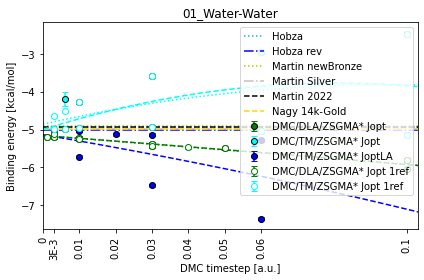

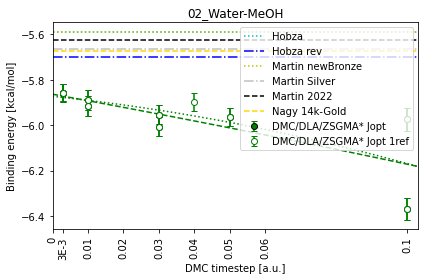

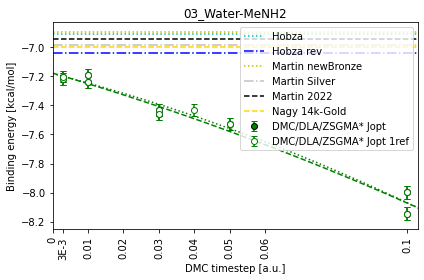

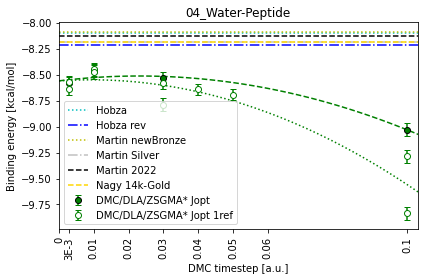

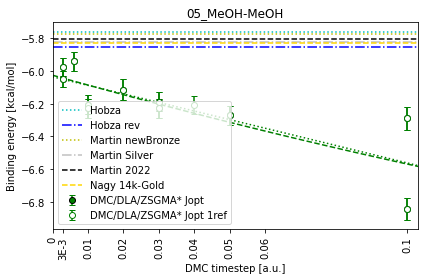

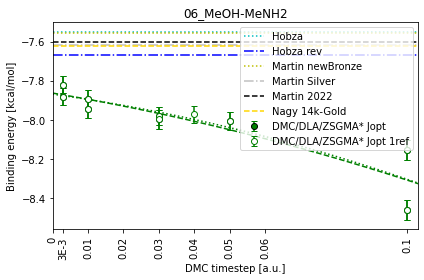

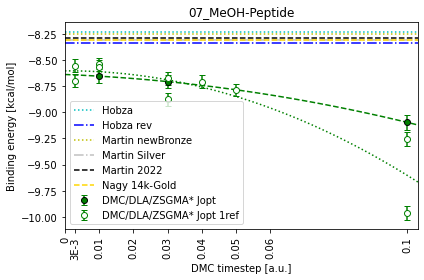

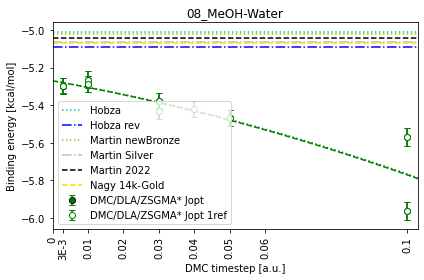

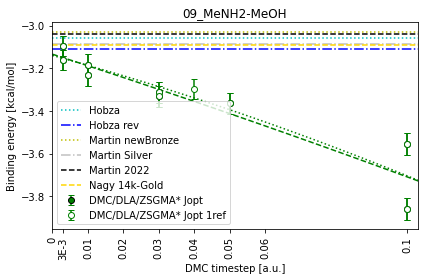

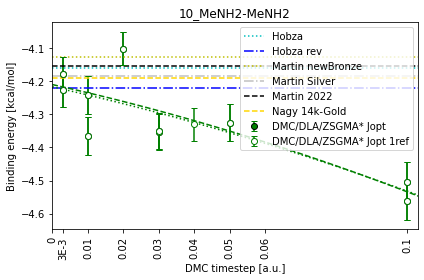

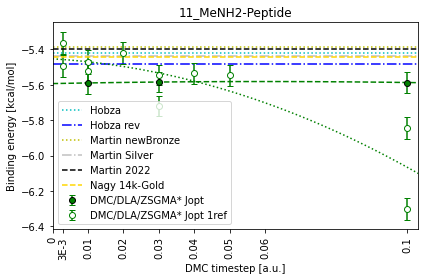

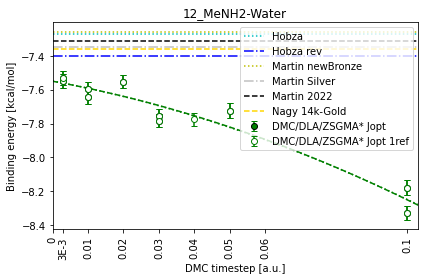

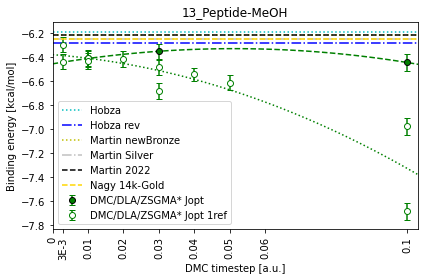

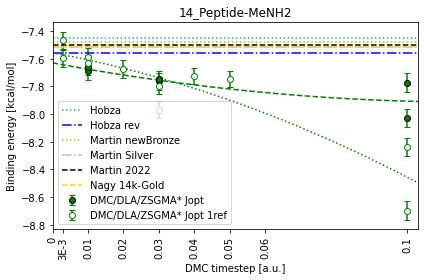

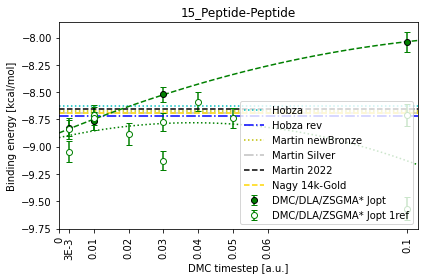

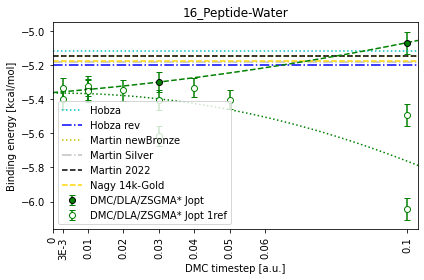

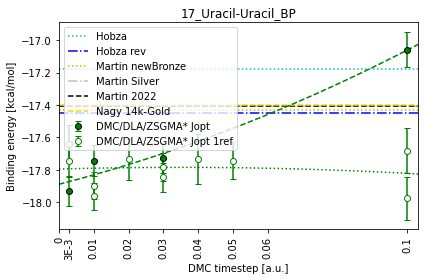

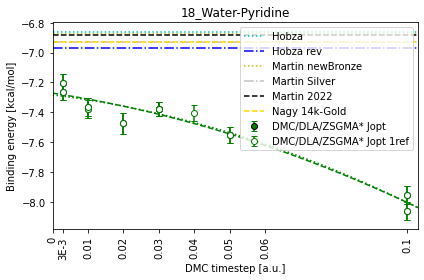

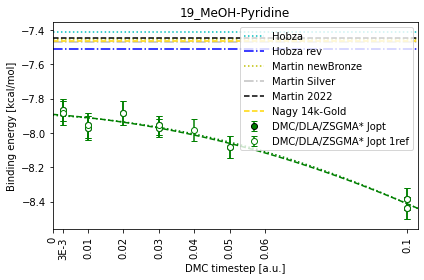

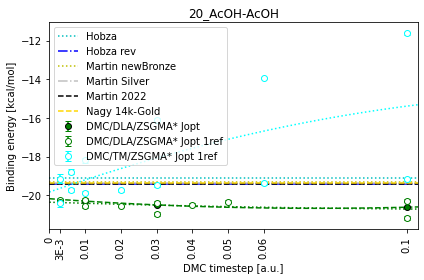

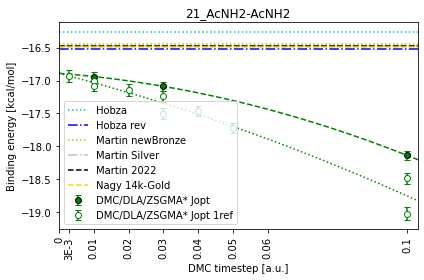

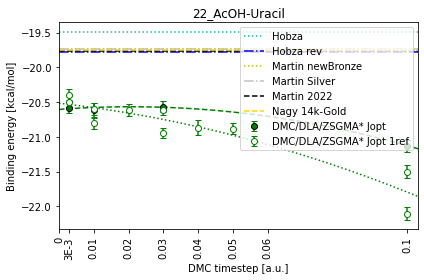

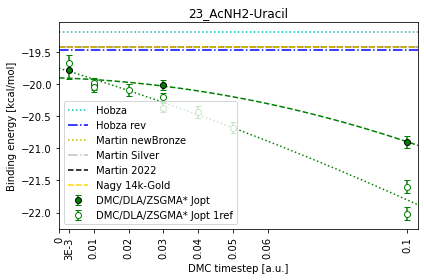

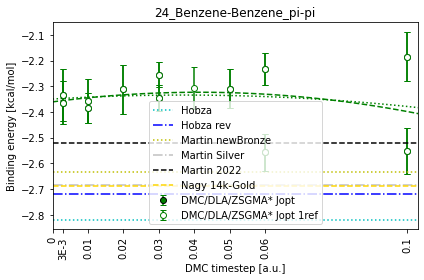

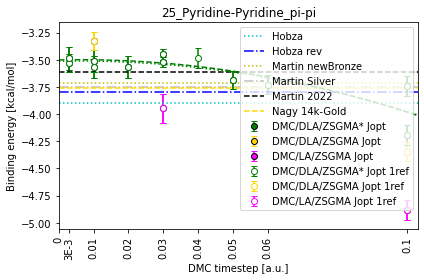

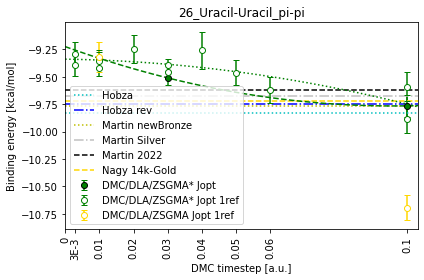

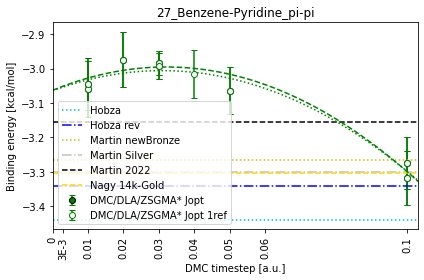

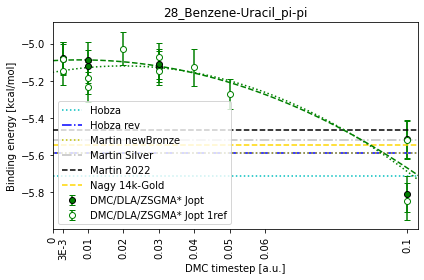

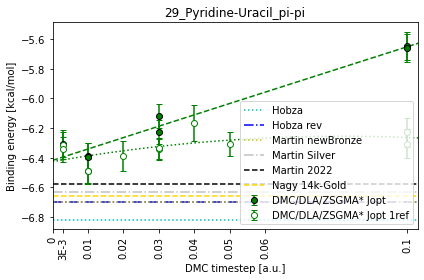

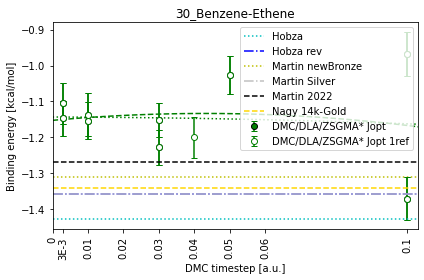

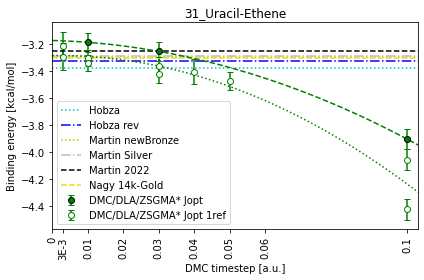

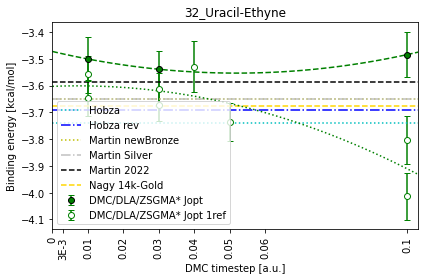

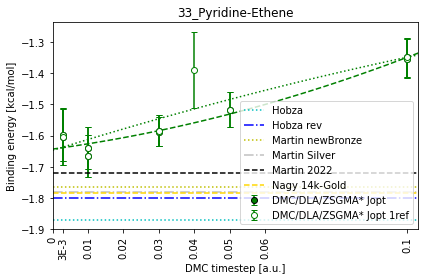

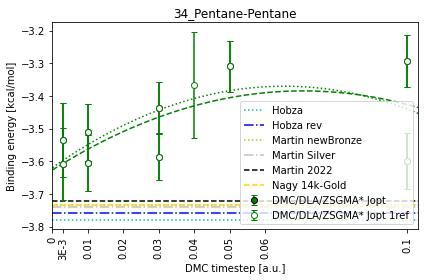

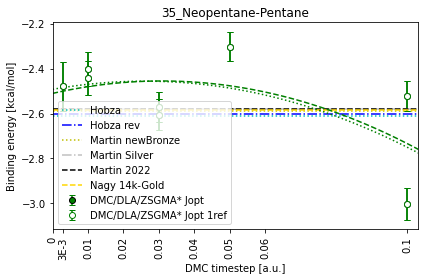

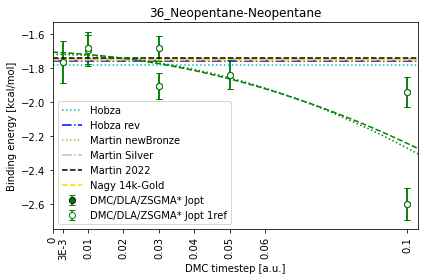

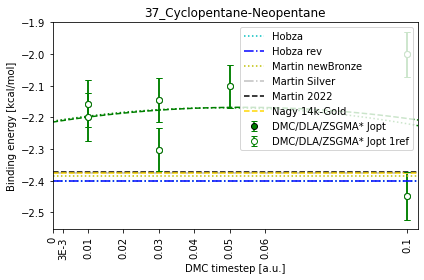

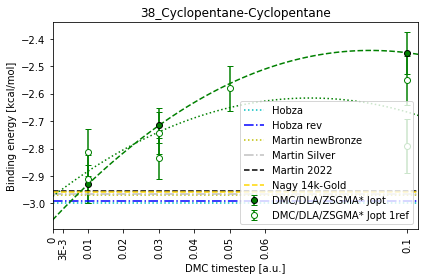

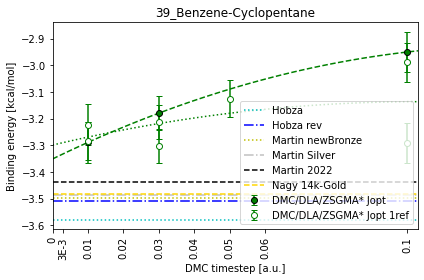

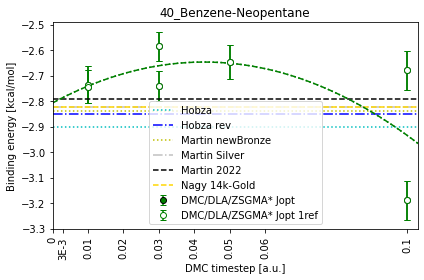

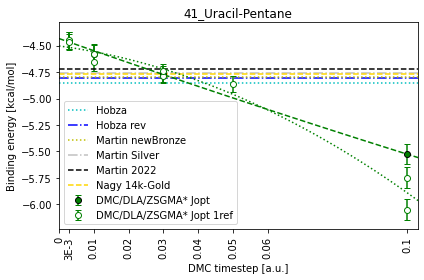

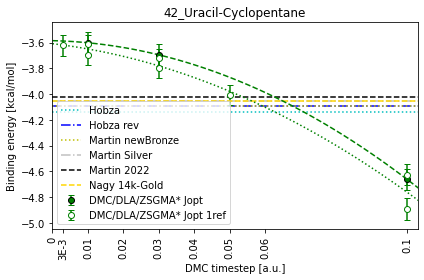

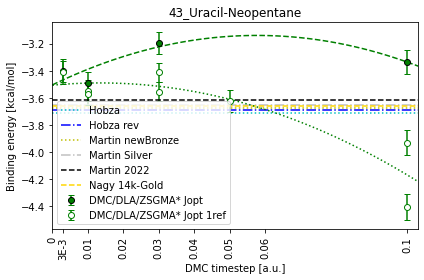

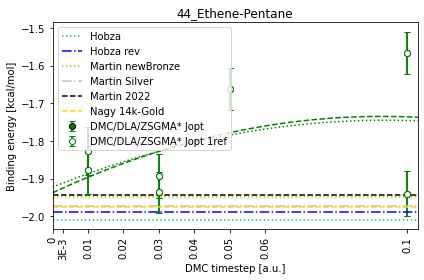

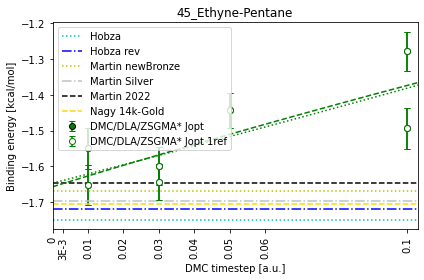

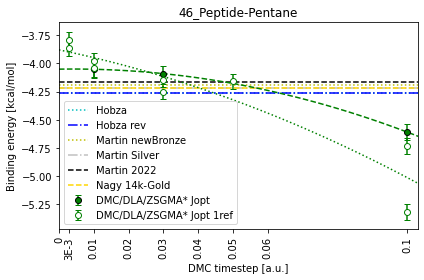

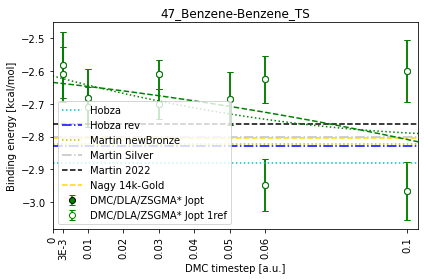

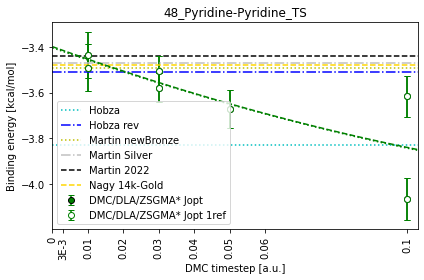

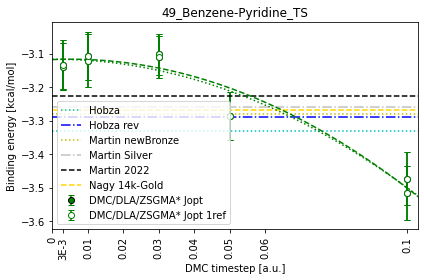

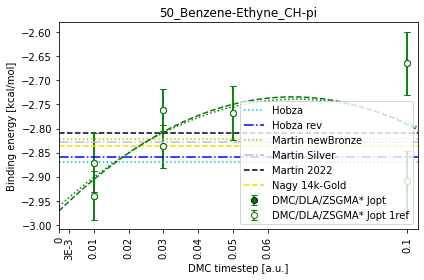

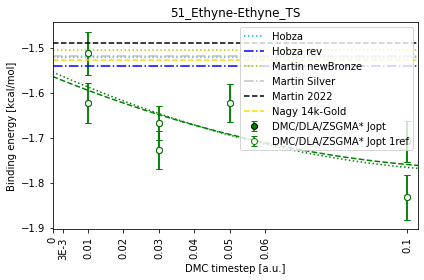

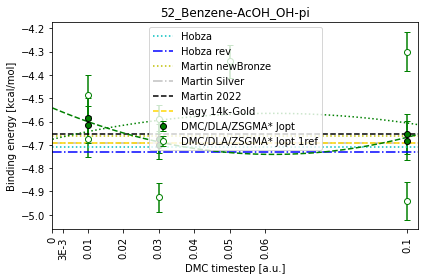

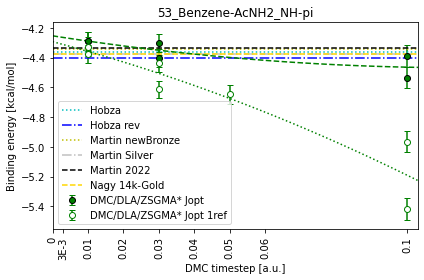

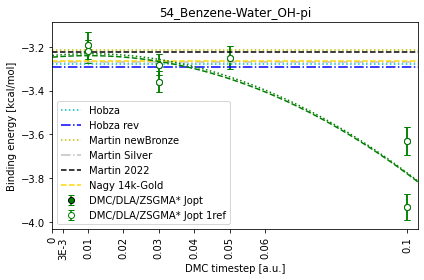

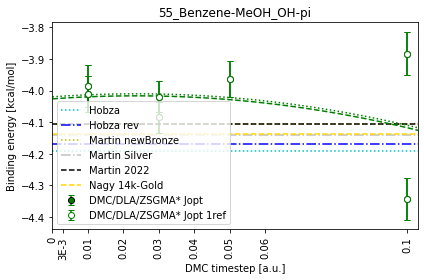

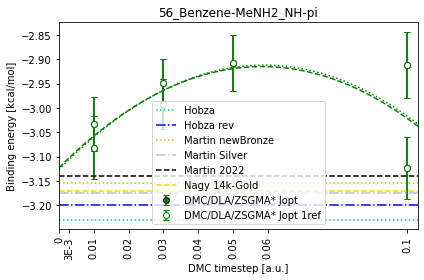

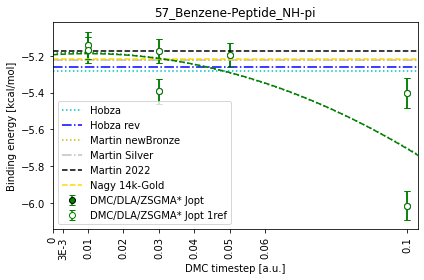

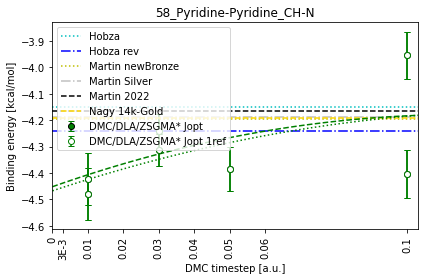

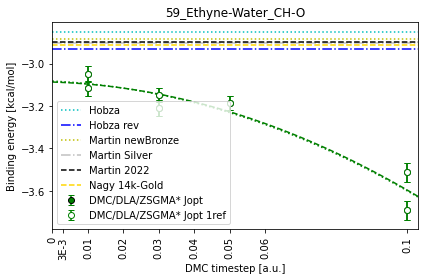

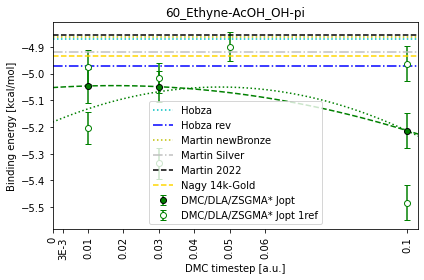

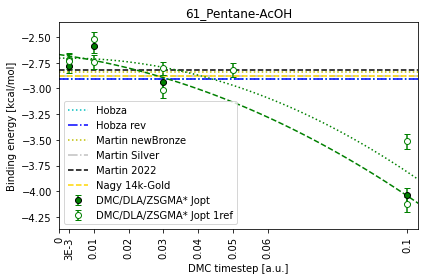

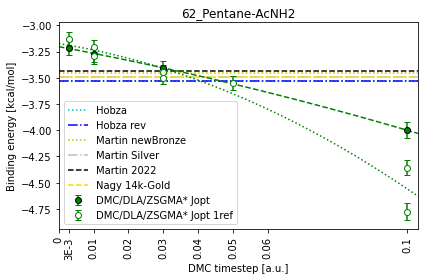

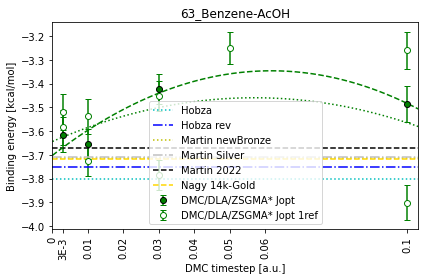

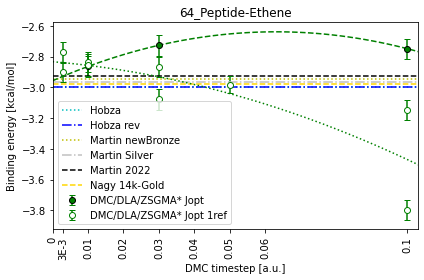

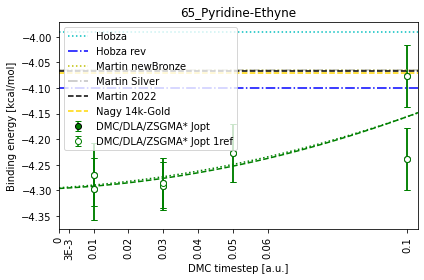

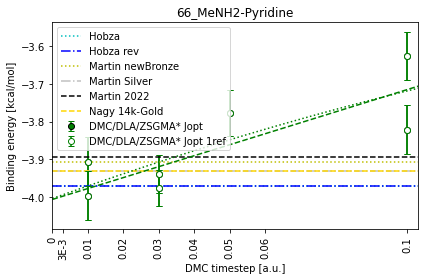

In [8]:
# Plot Binding Energy for 66 dimers using dataframe Eb
verbose = False

ref = {}
for i in range(1,67):
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_xlim( [0,0.103] )
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1 ] )
    ax.set_xticklabels( [ '0', '3E-3', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Binding energy [kcal/mol]' )
    
    # reference quantum-chemistry result
    ax.axhline( df_refs.loc[i,'Hobza_1'], c='c', ls=':', label='Hobza' )
    ax.axhline( df_refs.loc[i,'Hobza_2'], c='b', ls='-.', label='Hobza rev' )
    ax.axhline( df_refs.loc[i,'Martin_newBronze'], c='y', ls=':',  label='Martin newBronze' )
    ax.axhline( df_refs.loc[i,'Martin_Silver'], c='silver', ls='-.',  label='Martin Silver' )
    ax.axhline( df_refs.loc[i,'Martin_PCCP2022'], c='k', ls='--', label='Martin 2022' )
    ax.axhline( df_refs.loc[i,'14k-Gold'], c='gold', ls='--', label='Nagy 14k-Gold' )
    
    d = Eb[ Eb['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    ax.set_title( f'{name}' )
    print(f'{i} {name}')
    d = d[ d['tau']<0.11 ]
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        for Jas in Jas_set:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, label=label, color=c, mec='k', mfc=c, capsize=3, fmt='o' )
            #ax.plot( X, Y, 'o', label=label , color=c )

            try:
                ddfit = ddd[ ddd['tau']<=0.10 ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata, sigma=sigma )
                xlinspace = np.linspace( 0, 0.11, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, '--', color=c )
                if (dmc_type=='DMCdla5' and Jas=='Jopt'):
                    print(f'fit Eb = {popt[0]}')
                    ref[i] = popt[0]
            except:
                pass


    d = Eb_1ref[ Eb_1ref['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    d = d[ d['tau']<0.11 ]
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        #for Jas in Jas_set:
        for Jas in ['Jopt']:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, label=label+' 1ref', color=c, mec=c, mfc='white', capsize=3, fmt='o' )

            try:
                ddfit = ddd[ ddd['tau']<=0.10 ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata )
                xlinspace = np.linspace( 0, 0.11, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, ':', color=c )
                if (dmc_type=='DMCdla5' and Jas=='Jopt'):
                    print(f'fit Eb = {popt[0]}')
                    ref[i] = popt[0]
            except:
                pass
#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Eb_{i}.png',format='png',dpi=300)

s = pd.Series( ref )
df_refs['DMC'] = s.values

1 01_Water-Water
1 DMCdla5 Jopt
fit Eb = -5.15874796943942
1 DMCtm5 Jopt
2 02_Water-MeOH
2 DMCdla5 Jopt
fit Eb = -5.870906294281199
3 03_Water-MeNH2
3 DMCdla5 Jopt
fit Eb = -7.184085282755296
4 04_Water-Peptide
4 DMCdla5 Jopt
fit Eb = -8.56772162618213
5 05_MeOH-MeOH
5 DMCdla5 Jopt
fit Eb = -6.0307565961150305
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
fit Eb = -7.866897548031459
7 07_MeOH-Peptide
7 DMCdla5 Jopt
fit Eb = -8.60774881679035
8 08_MeOH-Water
8 DMCdla5 Jopt
fit Eb = -5.27174481178589
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
fit Eb = -3.1401529379645776
10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
fit Eb = -4.2083433950938405
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
fit Eb = -5.454484080610008
12 12_MeNH2-Water
12 DMCdla5 Jopt
fit Eb = -7.548062921371034
13 13_Peptide-MeOH
13 DMCdla5 Jopt
fit Eb = -6.3812708223327625
14 14_Peptide-MeNH2
14 DMCdla5 Jopt
fit Eb = -7.5611856085818765
15 15_Peptide-Peptide
15 DMCdla5 Jopt
fit Eb = -8.917945470252178
16 16_Peptide-Water
16 DMCdla5 Jopt
fit Eb = -5.367692952714284
17 

<ipython-input-9-8cabc0632224>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )


21 21_AcNH2-AcNH2
21 DMCdla5 Jopt
fit Eb = -16.886222033518727
22 22_AcOH-Uracil
22 DMCdla5 Jopt
fit Eb = -20.517841398222153
23 23_AcNH2-Uracil
23 DMCdla5 Jopt
fit Eb = -19.81713227435973
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
fit Eb = -2.361509731424013
25 25_Pyridine-Pyridine_pi-pi
25 DMCdla5 Jopt
fit Eb = -3.5067728177770556
25 DMCdla Jopt
25 DMC Jopt
26 26_Uracil-Uracil_pi-pi
26 DMCdla5 Jopt
fit Eb = -9.35242606050448
26 DMCdla Jopt
27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
fit Eb = -3.0589248241247553
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
fit Eb = -5.157555418030561
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
fit Eb = -6.417202319104484
30 30_Benzene-Ethene
30 DMCdla5 Jopt
fit Eb = -1.1476833148244694
31 31_Uracil-Ethene
31 DMCdla5 Jopt
fit Eb = -3.308101268805266
32 32_Uracil-Ethyne
32 DMCdla5 Jopt
fit Eb = -3.5922694707196663
33 33_Pyridine-Ethene
33 DMCdla5 Jopt
fit Eb = -1.6490660664188967
34 34_Pentane-Pentane
34 DMCdla5 Jopt
fit Eb = -3.6290371172401974
35 35_N

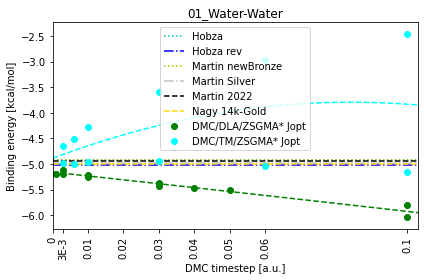

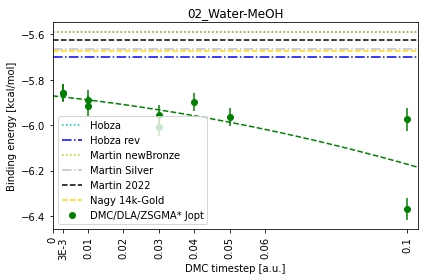

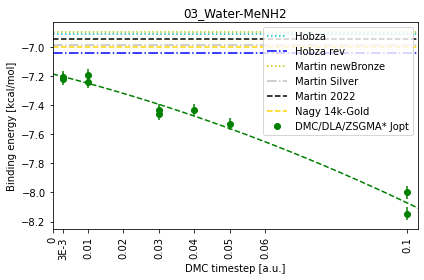

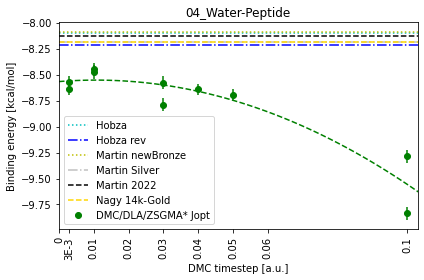

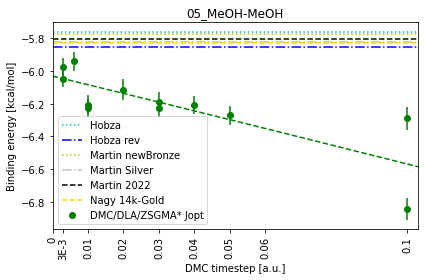

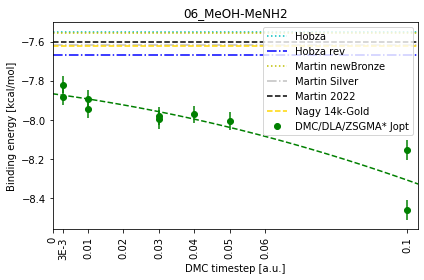

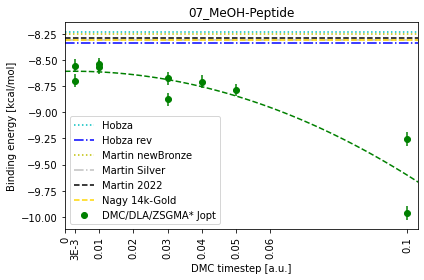

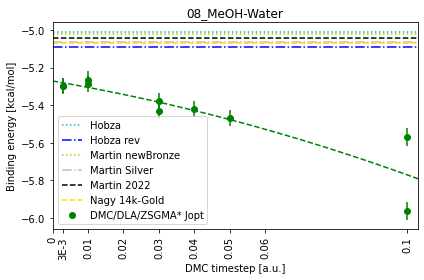

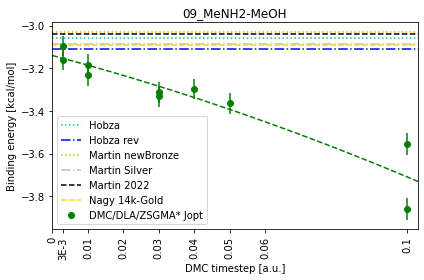

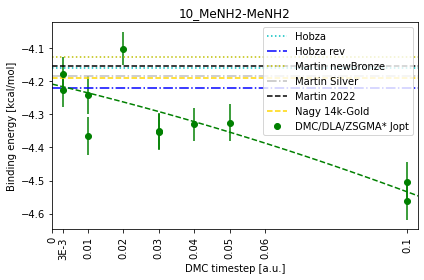

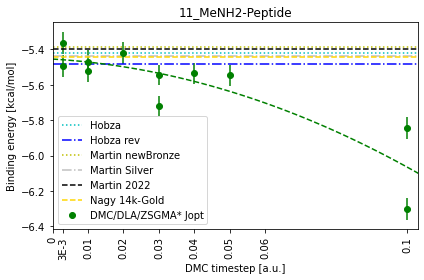

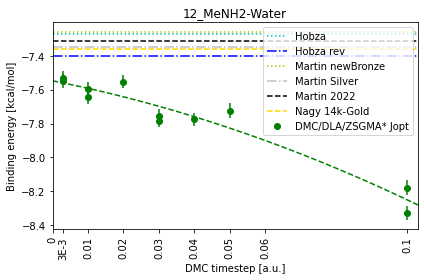

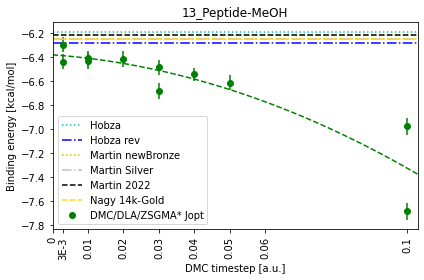

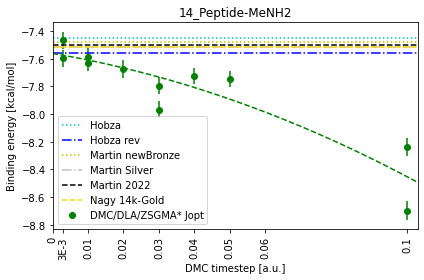

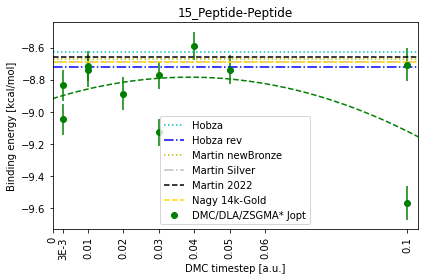

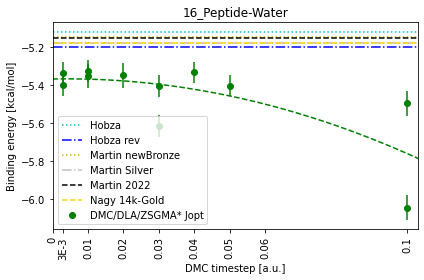

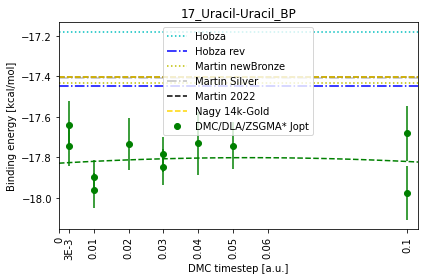

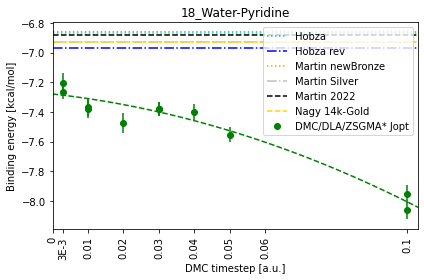

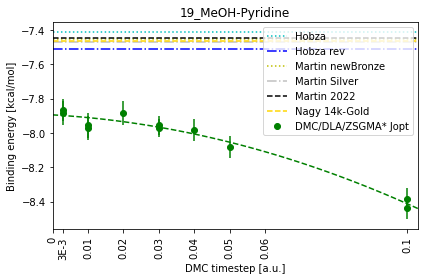

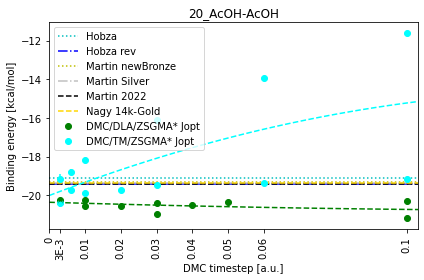

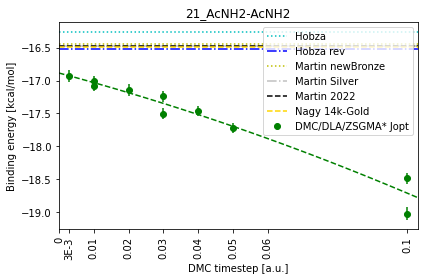

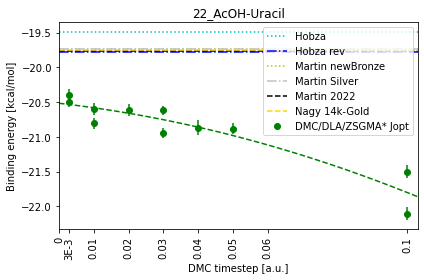

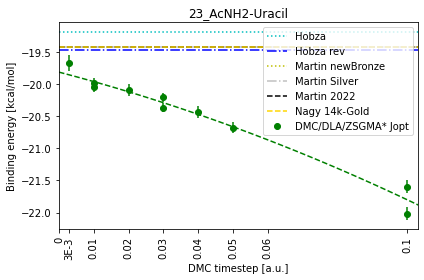

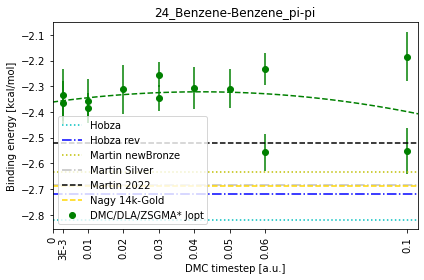

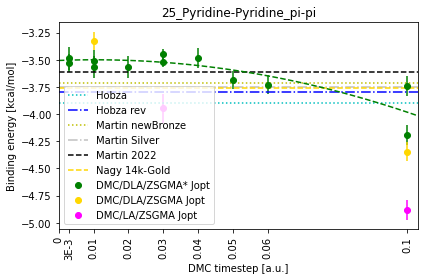

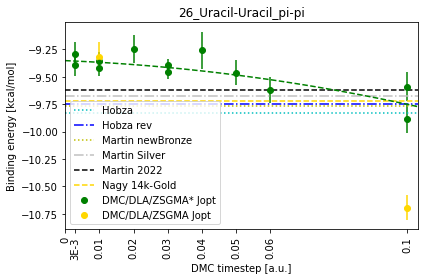

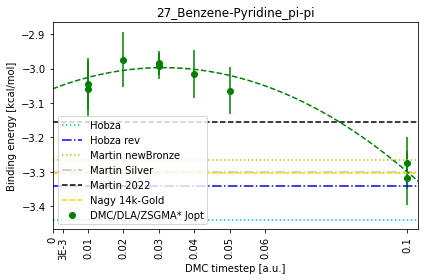

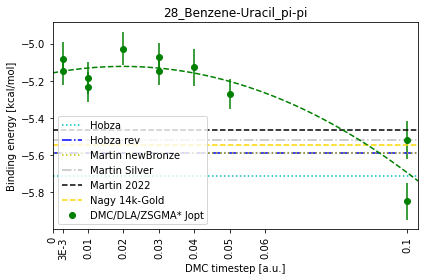

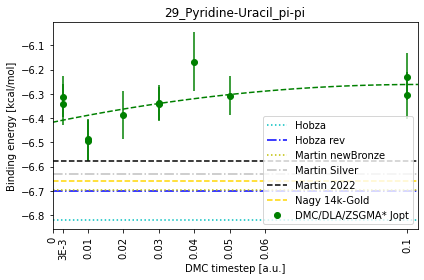

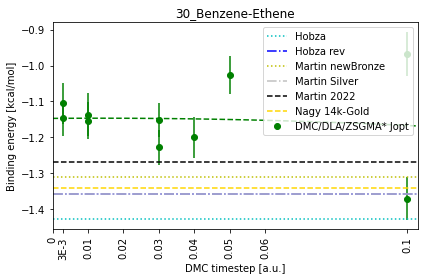

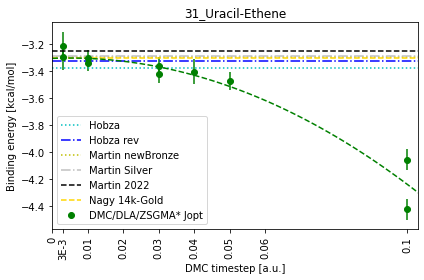

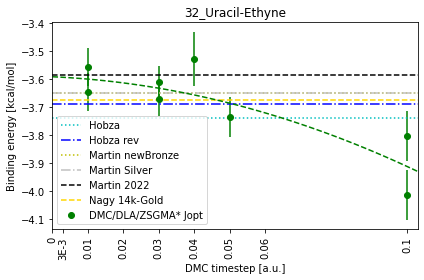

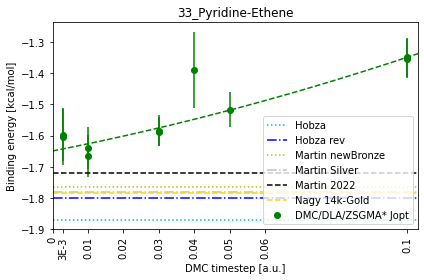

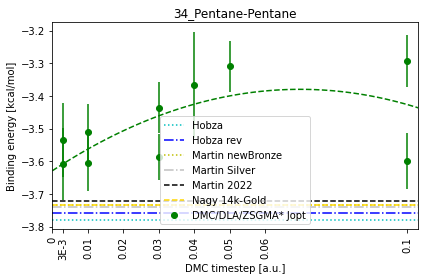

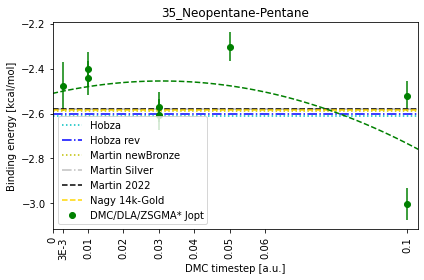

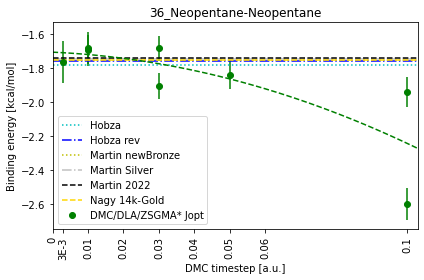

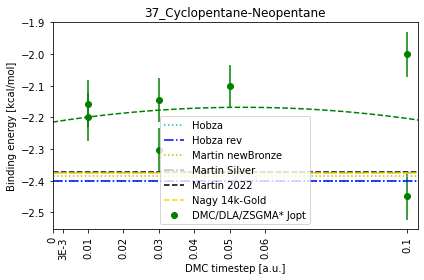

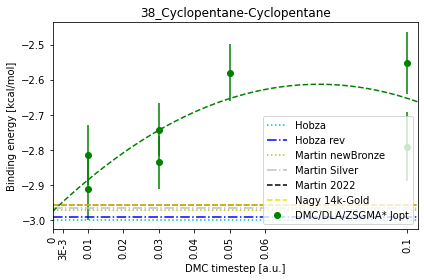

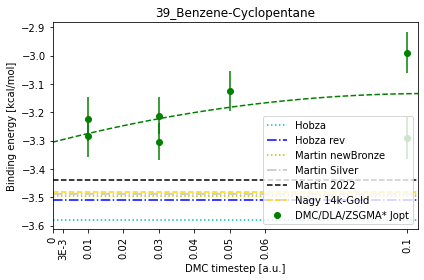

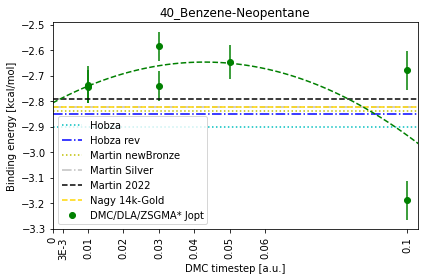

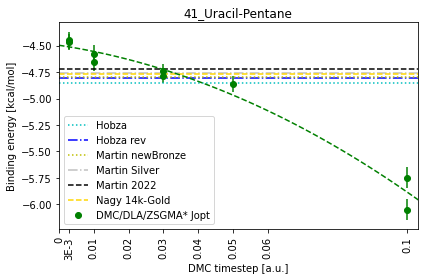

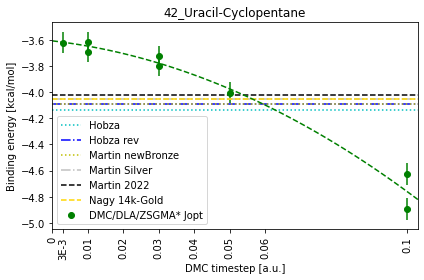

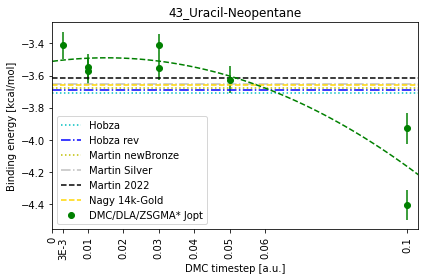

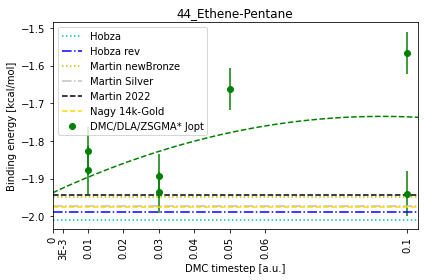

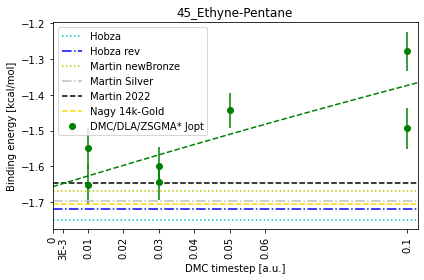

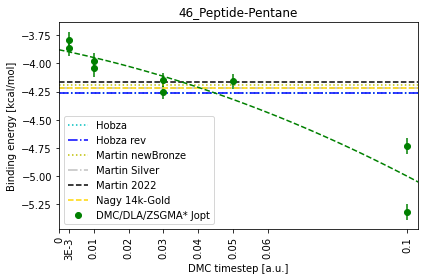

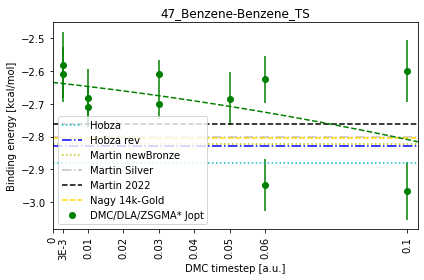

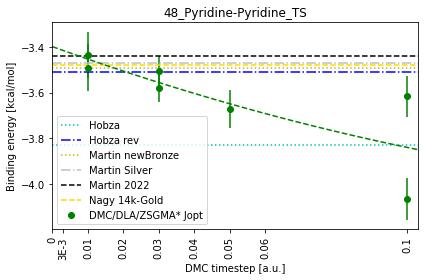

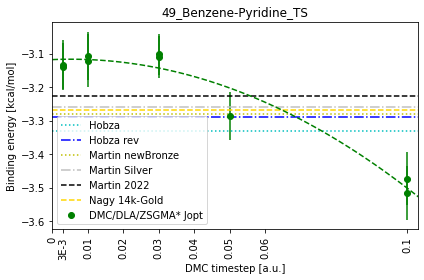

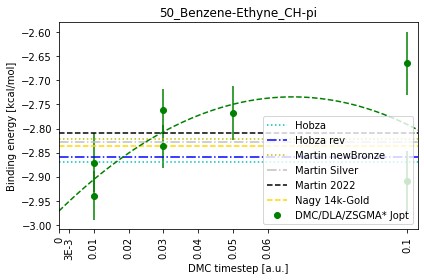

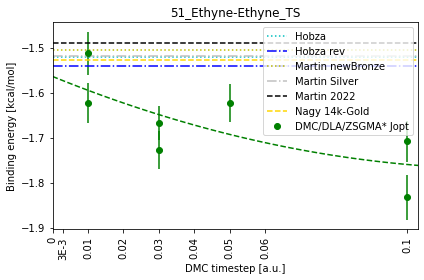

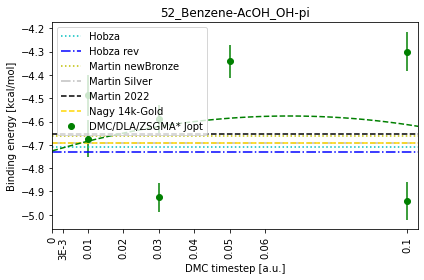

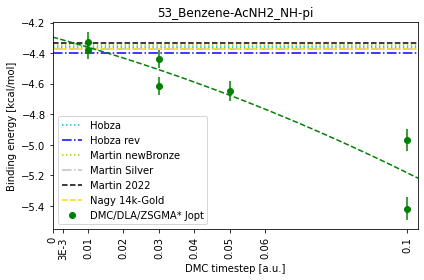

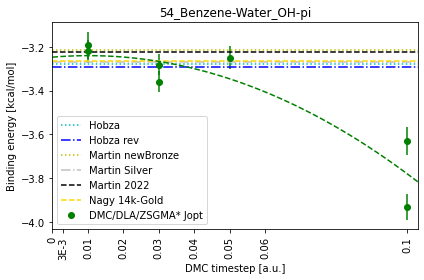

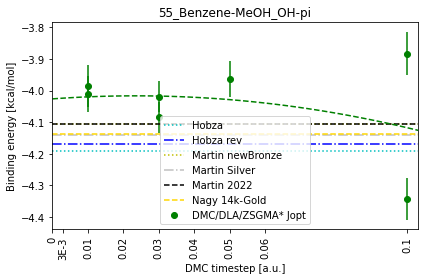

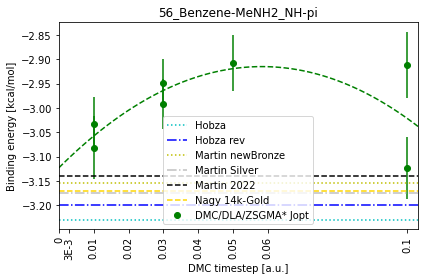

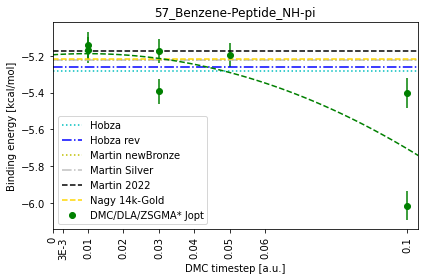

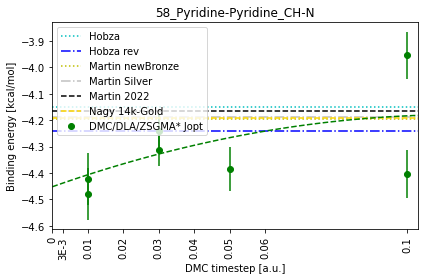

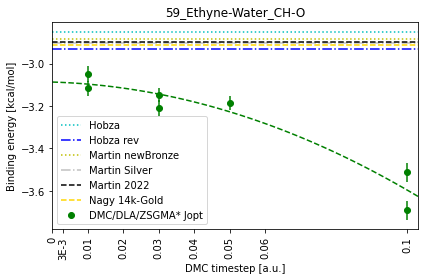

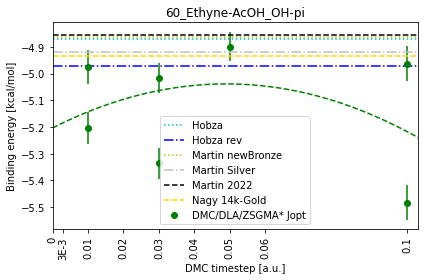

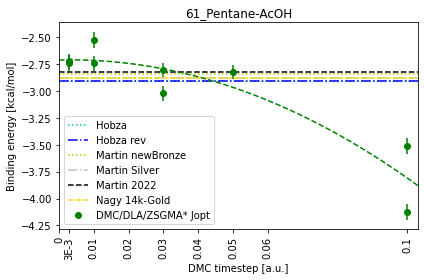

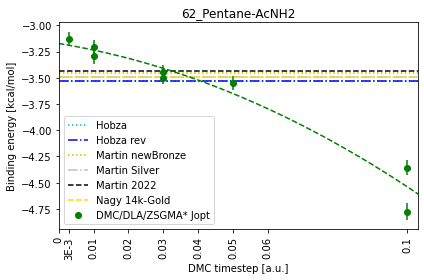

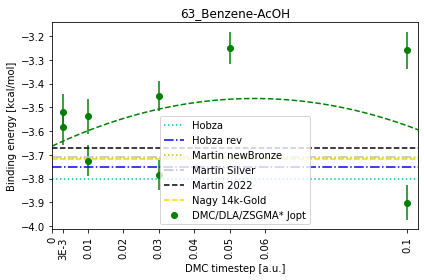

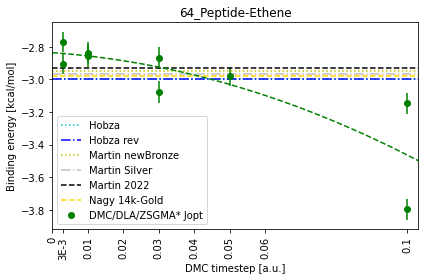

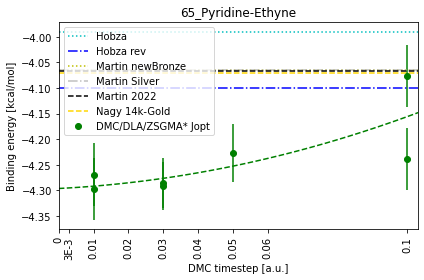

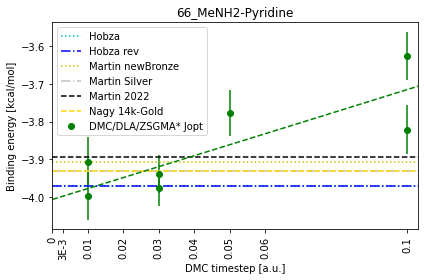

In [9]:
# Plot Binding Energy for 66 dimers using dataframe Eb_1ref
verbose = False

for i in range(1,67):
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_xlim( [0,0.103] )
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1 ] )
    ax.set_xticklabels( [ '0', '3E-3', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Binding energy [kcal/mol]' )
    
    # reference quantum-chemistry result
    ax.axhline( df_refs.loc[i,'Hobza_1'], c='c', ls=':', label='Hobza' )
    ax.axhline( df_refs.loc[i,'Hobza_2'], c='b', ls='-.', label='Hobza rev' )
    ax.axhline( df_refs.loc[i,'Martin_newBronze'], c='y', ls=':',  label='Martin newBronze' )
    ax.axhline( df_refs.loc[i,'Martin_Silver'], c='silver', ls='-.',  label='Martin Silver' )
    ax.axhline( df_refs.loc[i,'Martin_PCCP2022'], c='k', ls='--', label='Martin 2022' )
    ax.axhline( df_refs.loc[i,'14k-Gold'], c='gold', ls='--', label='Nagy 14k-Gold' )
    
    d = Eb_1ref[ Eb_1ref['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    ax.set_title( f'{name}' )

    d = d[ d['tau']<0.11 ]
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        #for Jas in Jas_set:
        for Jas in ['Jopt']:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o', label=label , color=c )

            try:
                ddfit = ddd[ ddd['tau']<=0.10 ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata, sigma=sigma )
                xlinspace = np.linspace( 0, 0.11, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, '--', color=c )
                if (dmc_type=='DMCdla5' and Jas=='Jopt'):
                    print(f'fit Eb = {popt[0]}')
                    ref[i] = popt[0]
            except:
                pass

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Eb1ref_{i}.png',format='png',dpi=300)


s = pd.Series( ref )
df_refs['DMC_1ref'] = s.values

In [10]:
df_refs

name  Hobza_1  Hobza_2  Martin_newBronze  Martin_Silver  \
1       01 Water-Water    -4.92    -5.01            -4.915         -4.982   
2        02 Water-MeOH    -5.59    -5.70            -5.589         -5.666   
3       03 Water-MeNH2    -6.91    -7.04            -6.894         -6.986   
4     04 Water-Peptide    -8.10    -8.22            -8.089         -8.183   
5         05 MeOH-MeOH    -5.76    -5.85            -5.773         -5.822   
..                 ...      ...      ...               ...            ...   
62    62 Pentane-AcNH2    -3.53    -3.53            -3.458         -3.491   
63     63 Benzene-AcOH    -3.80    -3.75            -3.715         -3.709   
64   64 Peptide-Ethene    -3.00    -3.00            -2.945         -2.967   
65  65 Pyridine-Ethyne    -3.99    -4.10            -4.065         -4.064   
66   66 MeNH2-Pyridine    -3.97    -3.97            -3.907         -3.930   

    Martin_Gold  Martin_PCCP2022  14k-Gold       DMC  DMC_1ref  
1        -4.979           -4.946    -4.991 -5.158204 -5.158748  
2        -5.666           -5.627    -5.674 -5.872926 -5.870906  
3        -6.985           -6.941    -6.996 -7.181421 -7.184085  
4           NaN           -8.128    -8.191 -8.561108 -8.567722  
5        -5.824           -5.804    -5.827 -6.035418 -6.030757  
..          ...              ...       ...       ...       ...  
62          NaN           -3.437    -3.495 -3.173335 -3.172506  
63          NaN           -3.671    -3.716 -3.643487 -3.662411  
64          NaN           -2.928    -2.977 -2.833053 -2.835571  
65          NaN           -4.066    -4.071 -4.295002 -4.296405  
66          NaN           -3.893    -3.931 -4.003776 -4.006261  

[66 rows x 10 columns]

In [11]:
aus = Eb.loc[ (Eb.Jas=='Jopt')&(Eb.dmc_type=='DMCdla5')&(Eb.tau==0.003) , ['ene','err','i'] ]
aus.index = aus.i.values
aus.drop(columns=['i'])

ene       err
1   -5.203357  0.039732
1   -5.121003  0.041473
2   -5.859280  0.039057
2   -5.856242  0.037935
3   -7.218353  0.038538
3   -7.201646  0.039632
4   -8.584681  0.056614
5   -5.973319  0.054768
5   -6.049598  0.050126
6   -7.820006  0.043533
6   -7.882615  0.042703
8   -5.299090  0.042160
8   -5.296052  0.041123
9   -3.096698  0.047923
9   -3.159306  0.047170
10  -4.176916  0.049455
10  -4.225855  0.051444
12  -7.547423  0.042428
12  -7.530715  0.043424
15  -8.829642  0.071470
17 -17.929089  0.092103
18  -7.262831  0.052634
18  -7.201745  0.061793
19  -7.867163  0.064454
19  -7.885393  0.071030
22 -20.578795  0.079755
23 -19.789381  0.129187
24  -2.334822  0.100676
24  -2.363350  0.083032
25  -3.527459  0.084447
25  -3.487641  0.105747
28  -5.075560  0.084624
28  -5.082914  0.083009
29  -6.310331  0.100781
30  -1.105148  0.057291
30  -1.147038  0.048939
33  -1.596460  0.084728
33  -1.604177  0.090081
34  -3.608332  0.109072
34  -3.534303  0.112591
35  -2.479911  0.108418
36  -1.763150  0.122264
41  -4.451623  0.081508
43  -3.400320  0.083112
47  -2.582216  0.101447
47  -2.610744  0.083965
49  -3.138373  0.071306
49  -3.132729  0.072712
61  -2.777775  0.070153
62  -3.215191  0.067234
63  -3.614525  0.074649

In [12]:
df_refs['DMC(0.003)'] = aus.ene
df_refs['err_DMC(0.003)'] = aus.err
df_refs

ValueError: cannot reindex from a duplicate axis

In [ ]:
aus = Eb.loc[ (Eb.Jas=='Jopt')&(Eb.dmc_type=='DMCdla5')&(Eb.tau==0.01) , ['ene','err','i'] ]
aus.index = aus.i.values
aus.drop(columns=['i'])
df_refs['DMC(0.01)'] = aus.ene
df_refs['err_DMC(0.01)'] = aus.err
df_refs

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
#fig, ax = plt.subplots()# figsize=(30,5) )
#df_refs.Hobza_1.plot( )
#df_refs.Hobza_2.plot( )
ax = df_refs.plot( xticks=range(1,67), rot=90, 
            title = 'S66 dataset of molecular dimers',
            xlabel = 'Dimer',
            ylabel = 'Binding Energy [kcal/mol]' )
ax.set_xticklabels( df_refs.name )
plt.tight_layout()
plt.savefig('Refs_all.png',dpi=300)
plt.rcdefaults()

In [ ]:
# Plot difference between references 

delta_refs = pd.DataFrame()
for i in df_refs.columns:
    if i != 'name' and not i.startswith('err') :
        print(i)
        delta_refs[i] = df_refs[i] - df_refs.Hobza_1

import matplotlib.pyplot as plt
fig, (ax2,ax) = plt.subplots( 1, 2, sharey=True, figsize=(10,12) )
#plt.rcParams["figure.figsize"] = (7, 12)
delta_refs.plot(kind='barh', rot=0, grid=True,
                title='Refs - Hobza_1', 
                xlabel='',
                ax=ax)
ax.set_yticklabels( df_refs.name )
ax.set_xlabel( r'$\Delta E$ [kcal/mol]' )
#for ref in ['Hobza_1','Hobza_2','Martin_newBronze','Martin_Silver']:
for ref in df_refs.columns:
    if ref != 'name' and not i.startswith('err'):
        ax2.plot( df_refs[ref], df_refs.index-1, 'o', label=ref )
ax2.set_xlabel( 'Binding Energy [kcal/mol]' )
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.savefig('Refs_all_delta.png',dpi=300)

plt.rcdefaults()

In [ ]:
# Plot relative difference between references 

rdelta_refs = delta_refs.copy()
for i in delta_refs.columns:
    rdelta_refs[i] = delta_refs[i] / df_refs.Hobza_1

fig, (ax,ax2) = plt.subplots( 1, 2, sharey=True, figsize=(10,12) )
delta_refs.plot(kind='barh', rot=0, grid=True,
                title='Difference: Ref - Hobza_1', 
                xlabel='',
                ax=ax)
ax.set_yticklabels( df_refs.name )
ax.set_xlabel( r'$\Delta E$ [kcal/mol]' )
rdelta_refs.plot(kind='barh', rot=0, grid=True,
                title='Relative difference', 
                xlabel='', legend=False,
                ax=ax2)
ax2.set_xlabel( r'$\Delta E / E$ ' )

plt.tight_layout()
plt.savefig('Refs_all_delta_relative.png',dpi=300)

plt.rcdefaults()

In [ ]:
# Plot relative difference between references 

fig, ax = plt.subplots()
delta_refs.plot.scatter( x='Hobza_2', y='DMC',
                title='Difference: Ref - Hobza_1', 
                ax=ax)
ax.set_xlabel( 'Hobza_2' )
ax.set_ylabel( 'DMC' )

plt.tight_layout()
plt.savefig('Refs_all_delta_scatter.png',dpi=300)

plt.rcdefaults()

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix( delta_refs.iloc[ :,1: ], alpha=0.5, figsize=(10,10) )